# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

#import markdown

import sys
import collections
import itertools

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

from IPython.display import display


'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv',sep=';')
#azdias.head()
print('azdias.shape',azdias.shape)

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv',sep=';')
feat_info.shape

cust = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv',sep=';')
dd = open('Data_Dictionary.md', 'r')
#f.read()

azdias.shape (891221, 85)


In [3]:
azdias.describe()
#azdias.info()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [4]:
pd.set_option('display.max_rows', 500)
azdias.isnull().sum().T

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias_orig = azdias.copy()
feat_info.head(6)
#feat_info.shape[0]
feat_info.info()
feat_info['missing_or_unknown']
azdias.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
for i,j in enumerate(feat_info['attribute'].values):   
    #print('--i , j--',i,j)
    miss_or_unk = feat_info[feat_info.attribute==j]['missing_or_unknown'].values
    #print('miss_or_unk',miss_or_unk)
    #print('miss_or_unk[0]',miss_or_unk[0])
    for i in range(len(miss_or_unk)):
        miss_or_unk[i] = miss_or_unk[i].strip('[]').split(',')
        #print('miss_or_unk[i]',miss_or_unk[i])
    #print('miss_or_unk',miss_or_unk[0]) 
    for i in range(len(miss_or_unk[0])):
        if miss_or_unk[0][i]!='X' and miss_or_unk[0][i]!='XX' and miss_or_unk[0][i]!='' and miss_or_unk[0][i] != ['']:
            miss_or_unk[0][i] = int(miss_or_unk[0][i])
        else:
            miss_or_unk[0] = miss_or_unk[0][i]
        #print('miss_or_unk[i]',miss_or_unk[i])
        #print('miss_or_unk[0]',miss_or_unk[0])
    #print(miss_or_unk[0])
    azdias[j] = azdias[j].replace(miss_or_unk[0], np.nan)

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
# after replacement
print('original shape',azdias_orig.shape)
print('new shape',azdias.shape)

#azdias.isnull().sum() == azdias_orig.isnull().sum()

print('original missing values:',azdias_orig.isnull().sum().sum())
print('after replacement missing values:',azdias.isnull().sum().sum())

original shape (891221, 85)
new shape (891221, 85)
original missing values: 4896838
after replacement missing values: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
miss_per = (azdias.isnull().sum()/azdias.shape[0])*100
miss_pers = miss_per.sort_values()
miss_per.sort_values(ascending = False)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

In [9]:
#!pip3 install -U matplotlib

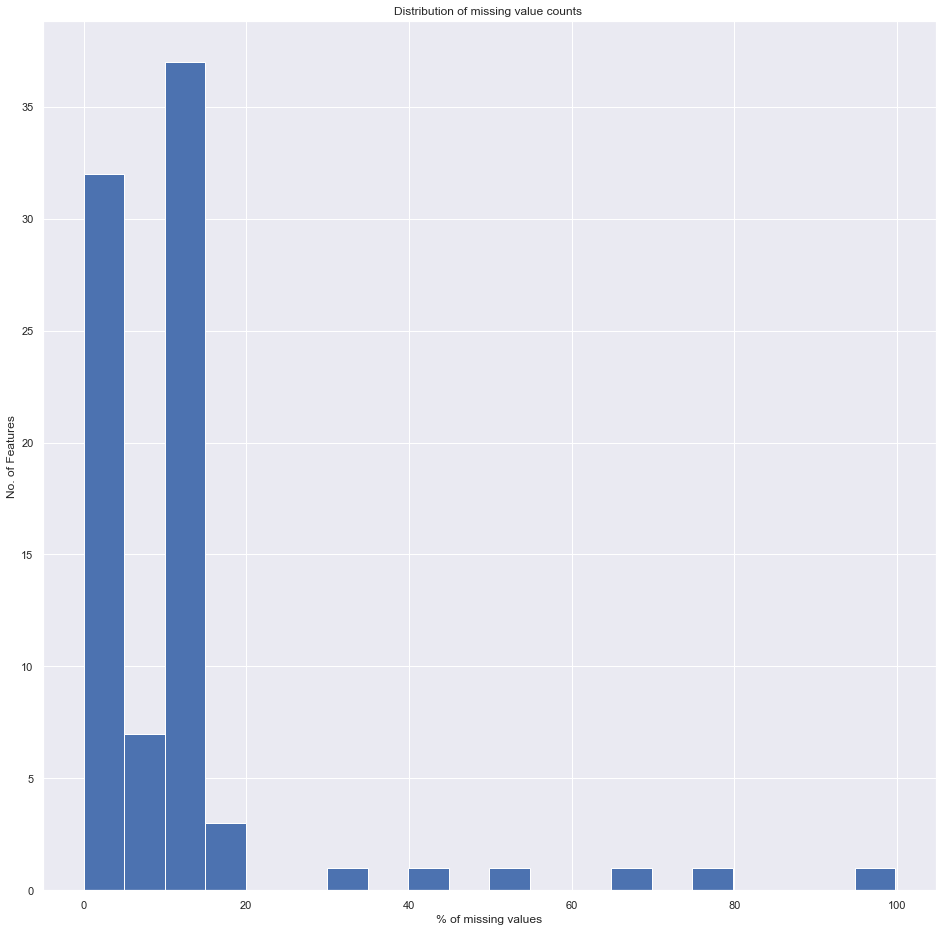

In [10]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
sns.set(rc={'figure.figsize':(16,16)})
plt.hist(miss_pers, bins = 20, align = 'mid')
plt.ylabel('No. of Features')
plt.xlabel('% of missing values')
plt.title('Distribution of missing value counts ')
plt.show()



In [11]:
# Investigate patterns in the amount of missing data in each column.
outliers = []
count1 = 0
count2 = 0
count3 = 0
count4 = 0
for i,j in enumerate(feat_info['attribute'].values):
    miss = (azdias[j].isnull().sum()/azdias.shape[0])*100
    if miss < 25:
        count1+=1
    elif 25 < miss < 50:
        count2+=1
        outliers.append(j)
    elif 50 < miss < 75:
        count3+=1
        outliers.append(j)
    else:
        count4+=1
        outliers.append(j)
        print('{:.2f}% of data is missing in the attribute: {}'.format(miss,j))
        
print('{} of features has missing data less than 25%:'.format(count1))
print('{} of features has missing data btw 25 and 50%:'.format(count2))
print('{} of features has missing data btw 50 and 75%:'.format(count3))
print('{} of features has missing data more than 75%'.format(count3))


print('\nOutliers based on missing value % greater than 25% \n',outliers)


76.96% of data is missing in the attribute: AGER_TYP
99.76% of data is missing in the attribute: TITEL_KZ
79 of features has missing data less than 25%:
2 of features has missing data btw 25 and 50%:
2 of features has missing data btw 50 and 75%:
2 of features has missing data more than 75%

Outliers based on missing value % greater than 25% 
 ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_2 = azdias.drop(outliers, axis = 1)
#feat_info_2 = feat_info[-feat_info.attribute.isin(outliers)]
# Six outliers are dropped
azdias_2.shape



(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)
    
    Six columns, ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'] has missing values more than 30%, hence those columns are dropped

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [13]:
''' 
# Donot run this cell as this is only informative and taking long time as compare to other code blocks in the notebook

#Coutliers = []
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
for i in range(azdias_2.shape[0]):
    col_miss = azdias_2.iloc[i].isnull().sum()
    miss_per = (azdias_2.iloc[i].isnull().sum()/azdias_2.shape[1])*100
    #print(col_miss,'----',miss_per)
    if miss_per == 0:
        count1+=1
    if 0 < miss_per <= 25:
        count2+=1
    elif 25 < miss_per <= 50:
        count3+=1
        #Coutliers.append(j)
    elif 50 < miss_per <= 75:
        count4+=1
        #Coutliers.append(j)
    elif miss_per > 75:
        count5+=1
        #Coutliers.append(j)
        #print('{:.2f}% of data is missing in the attribute: {}'.format(miss,j))
        
print('{} of rows with no missing data'.format(count1))
print('{} of rows has missing data less than 25%:'.format(count2))
print('{} of rows has missing data btw 25 and 50%:'.format(count3))
print('{} of rows has missing data btw 50 and 75%:'.format(count4))
print('{} of rows has missing data more than 75%, good candidate for dropping the records'.format(count5))
'''

" \n# Donot run this cell as this is only informative and taking long time as compare to other code blocks in the notebook\n\n#Coutliers = []\ncount1 = 0\ncount2 = 0\ncount3 = 0\ncount4 = 0\ncount5 = 0\nfor i in range(azdias_2.shape[0]):\n    col_miss = azdias_2.iloc[i].isnull().sum()\n    miss_per = (azdias_2.iloc[i].isnull().sum()/azdias_2.shape[1])*100\n    #print(col_miss,'----',miss_per)\n    if miss_per == 0:\n        count1+=1\n    if 0 < miss_per <= 25:\n        count2+=1\n    elif 25 < miss_per <= 50:\n        count3+=1\n        #Coutliers.append(j)\n    elif 50 < miss_per <= 75:\n        count4+=1\n        #Coutliers.append(j)\n    elif miss_per > 75:\n        count5+=1\n        #Coutliers.append(j)\n        #print('{:.2f}% of data is missing in the attribute: {}'.format(miss,j))\n        \nprint('{} of rows with no missing data'.format(count1))\nprint('{} of rows has missing data less than 25%:'.format(count2))\nprint('{} of rows has missing data btw 25 and 50%:'.format(coun

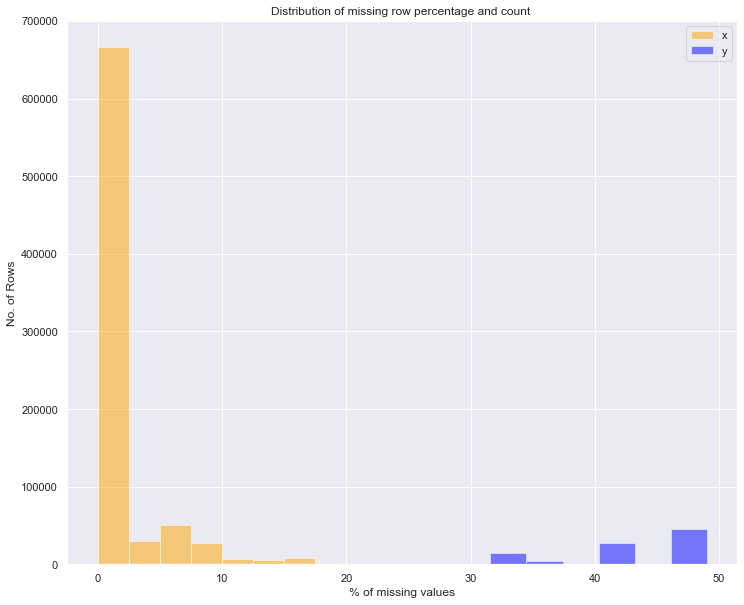

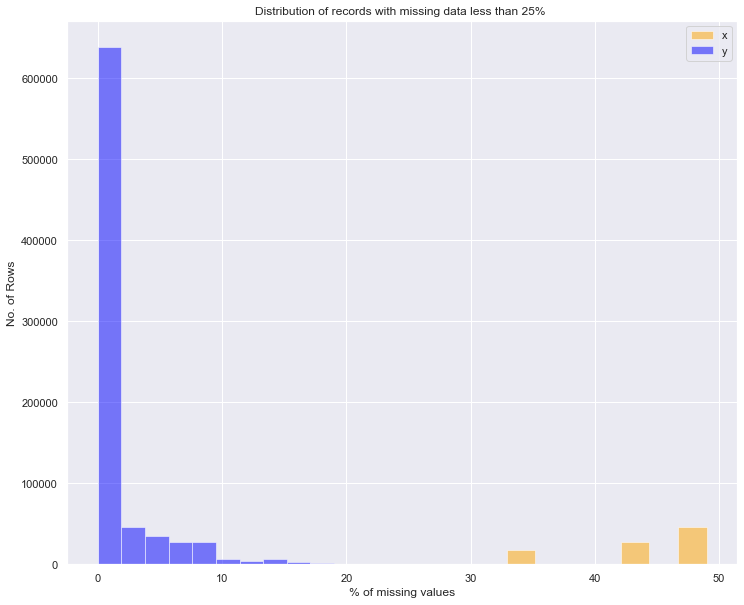

In [14]:
# How much data is missing in each row of the dataset?

col_miss_plt, col_miss_plt_0 = [],[]
miss_per_plt, miss_per_plt_0 = [],[]

for i in range(azdias_2.shape[0]):
    col_miss = azdias_2.iloc[i].isnull().sum()    
    miss_per = (azdias_2.iloc[i].isnull().sum()/azdias_2.shape[1])*100
    if col_miss <= 25:
        col_miss_plt.append(col_miss)
    else:
        col_miss_plt_0.append(col_miss)
    if miss_per > 25:
        miss_per_plt.append(col_miss)
    else:
        miss_per_plt_0.append(col_miss)
#print(col_miss_plt)
sns.set(rc={'figure.figsize':(12,10)})
#bins = np.linspace(-10, 10, 100)
plt.ylabel('No. of Rows')
plt.xlabel('% of missing values')
plt.title('Distribution of missing row percentage and count ')
plt.hist(col_miss_plt, bins=10, alpha=0.5, label='x', color = 'orange')
plt.hist(miss_per_plt, bins=10, alpha=0.5, label='y', color = 'blue')
plt.legend(loc='upper right')
plt.show()

sns.set(rc={'figure.figsize':(12,10)})
#bins = np.linspace(-10, 10, 100)
plt.ylabel('No. of Rows')
plt.xlabel('% of missing values')
plt.title('Distribution of records with missing data less than 25% ')
plt.hist(col_miss_plt_0, bins=10, alpha=0.5, label='x', color = 'orange')
plt.hist(miss_per_plt_0, bins=10, alpha=0.5, label='y', color = 'blue')
plt.legend(loc='upper right')
plt.show()    



In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_lt_25 = azdias_2[(azdias_2.isnull().sum(axis=1)/azdias_2.shape[1])*100 <= 25]
azdias_gt_25 = azdias_2[(azdias_2.isnull().sum(axis=1)/azdias_2.shape[1])*100 > 25]

lt_25 = azdias_lt_25.shape
gt_25 = azdias_gt_25.shape



In [16]:
print(azdias_lt_25.shape)
print(azdias_gt_25.shape)

print('{:.2f}% data in moved into the first group and {:.2f}% in the second group'.format((lt_25[0]/azdias_2.shape[0])*100,(gt_25[0]/azdias_2.shape[0])*100))



(797077, 79)
(94144, 79)
89.44% data in moved into the first group and 10.56% in the second group


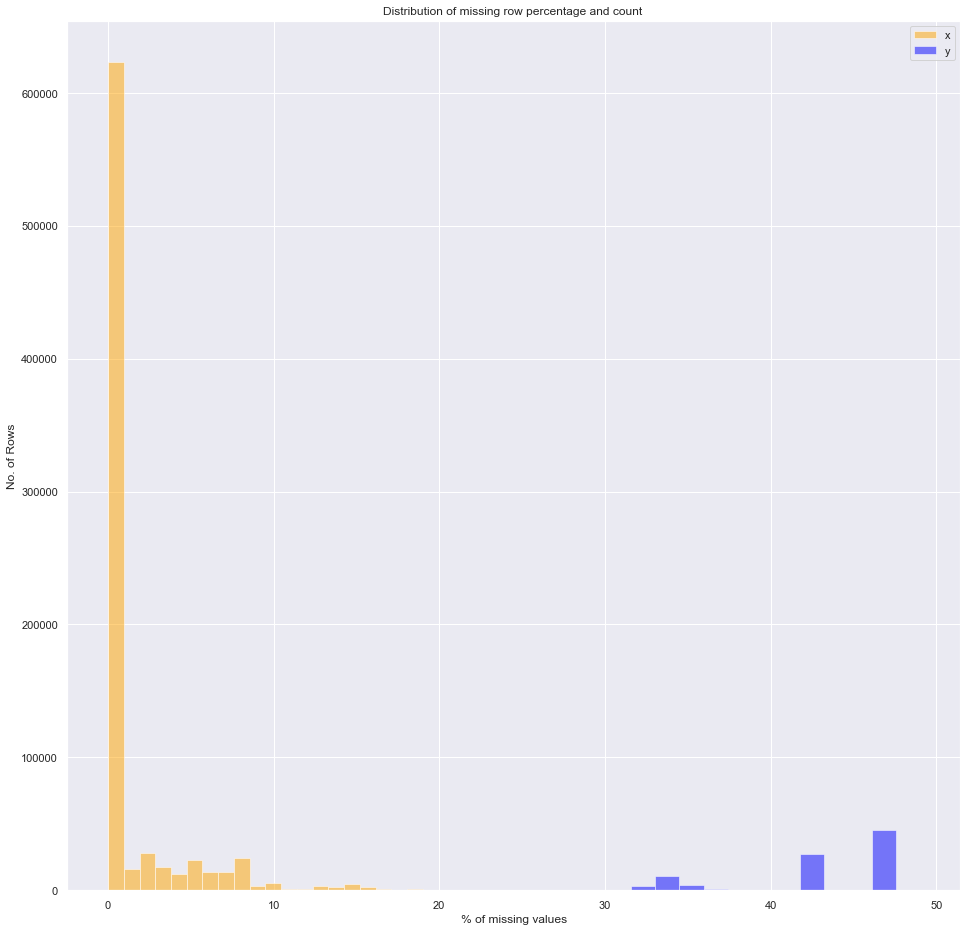

In [17]:
azdias_lt_25_miss = azdias_lt_25.isnull().sum(axis=1)
azdias_gt_25_miss = azdias_gt_25.isnull().sum(axis=1)

sns.set(rc={'figure.figsize':(16,16)})
#bins = np.linspace(-10, 10, 100)
plt.ylabel('No. of Rows')
plt.xlabel('% of missing values')
plt.title('Distribution of missing row percentage and count ')
plt.hist(azdias_lt_25_miss, bins= 20, alpha=0.5, label='x', color = 'orange')
plt.hist(azdias_gt_25_miss, bins= 20, alpha=0.5, label='y', color = 'blue')
plt.legend(loc='upper right')
plt.show()

/Users/pp/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/pp/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


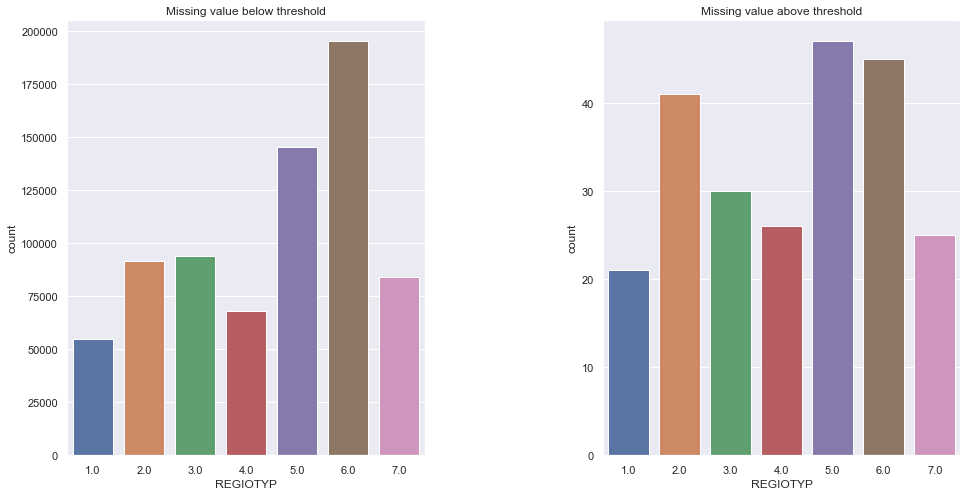

In [18]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
sns.set(rc={'figure.figsize':(16,8)})

fig, axes = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.50)
axes[0].title.set_text('Missing value below threshold')
sns.countplot(azdias_lt_25['REGIOTYP'], ax=axes[0])
axes[1].title.set_text('Missing value above threshold')
sns.countplot(azdias_gt_25['REGIOTYP'], ax=axes[1])
plt.show()

#Ref: https://stackoverflow.com/questions/45069828/how-to-plot-2-histograms-side-by-side


/Users/pp/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/pp/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


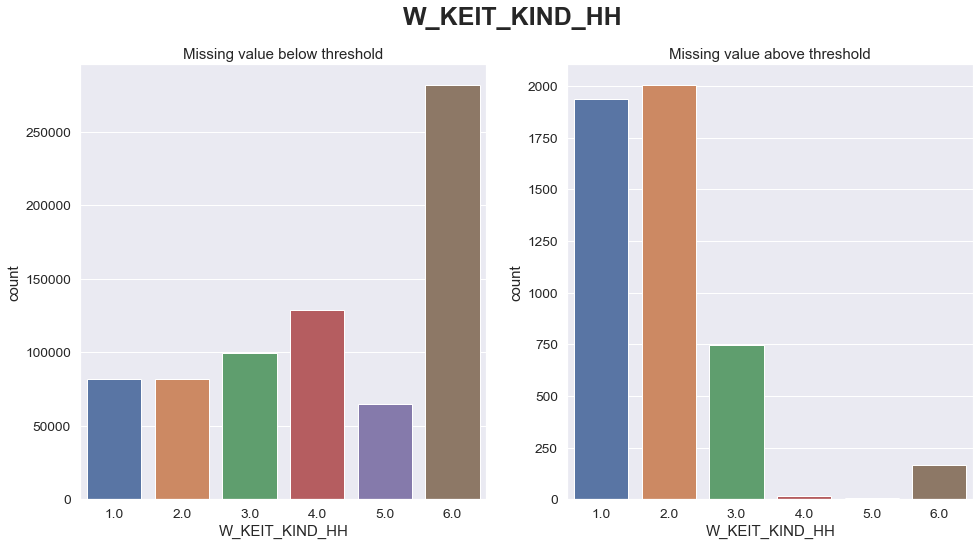

/Users/pp/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/pp/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


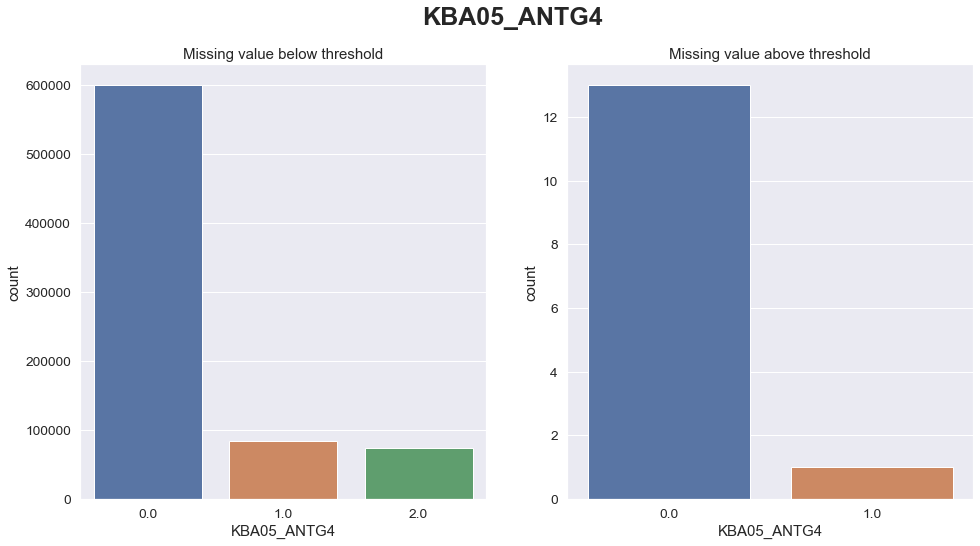

/Users/pp/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/pp/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


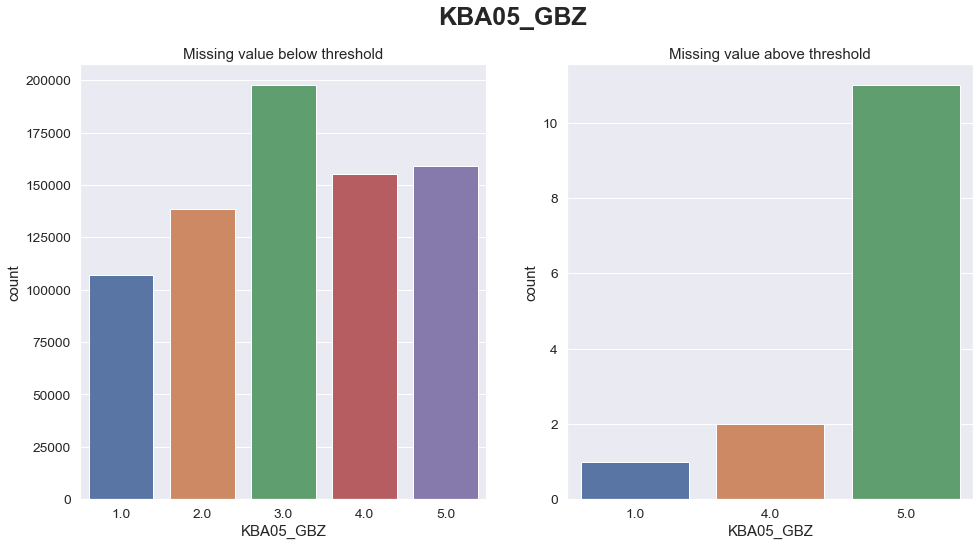

/Users/pp/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/pp/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


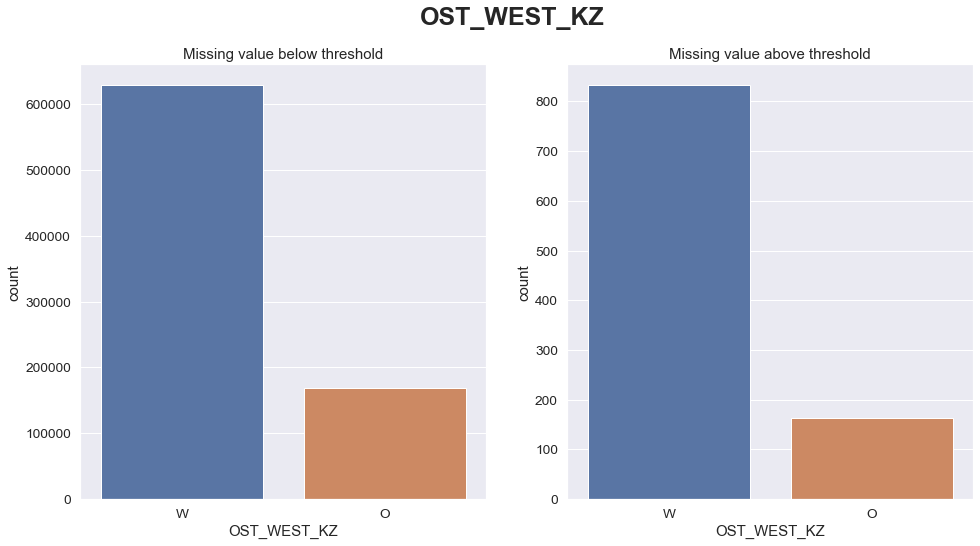

/Users/pp/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/pp/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


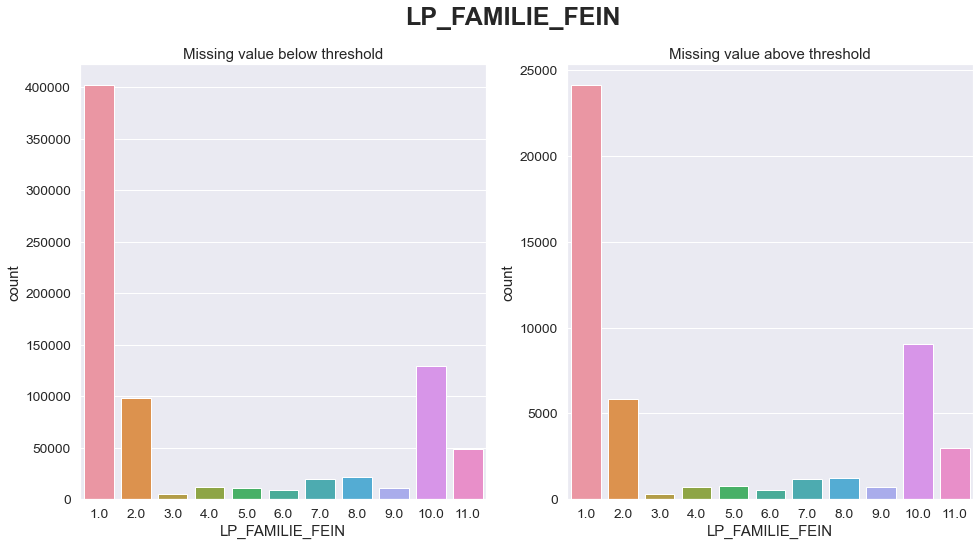

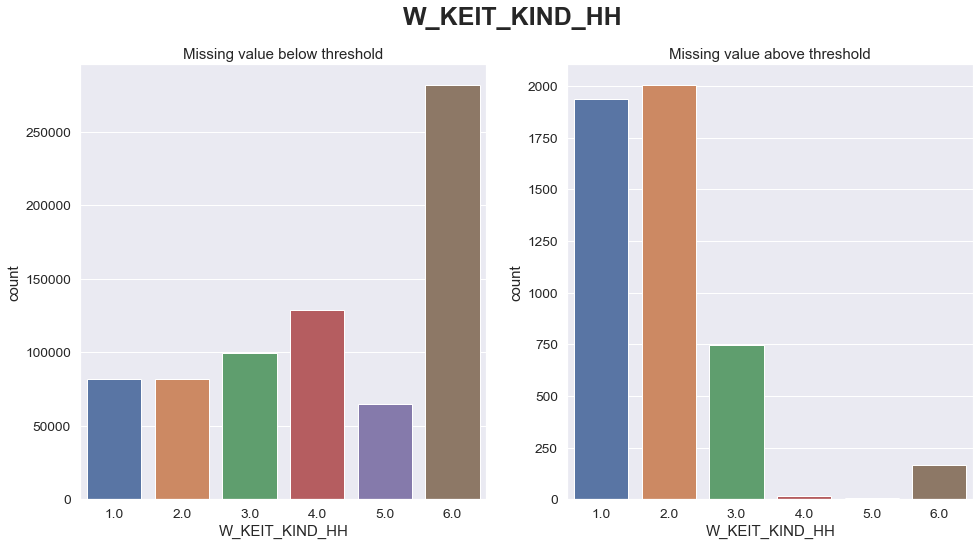

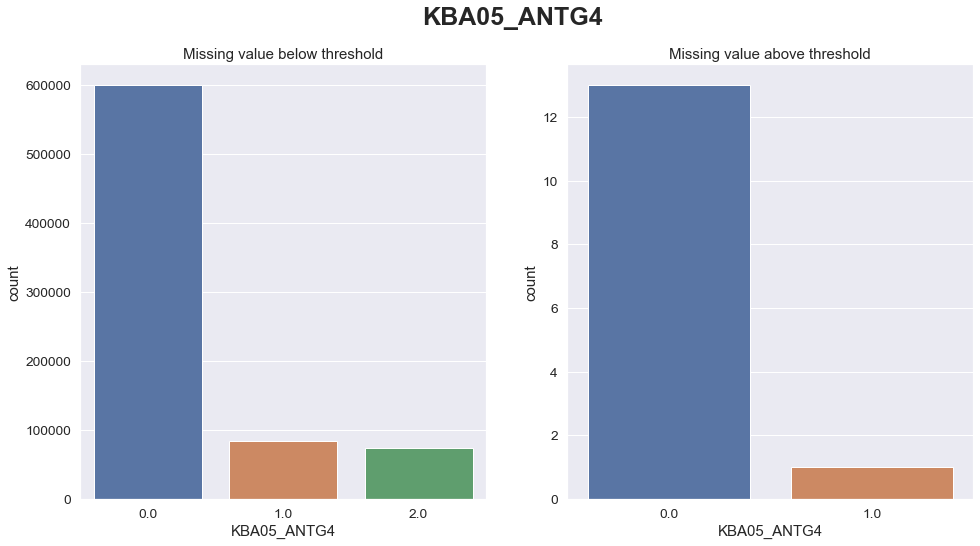

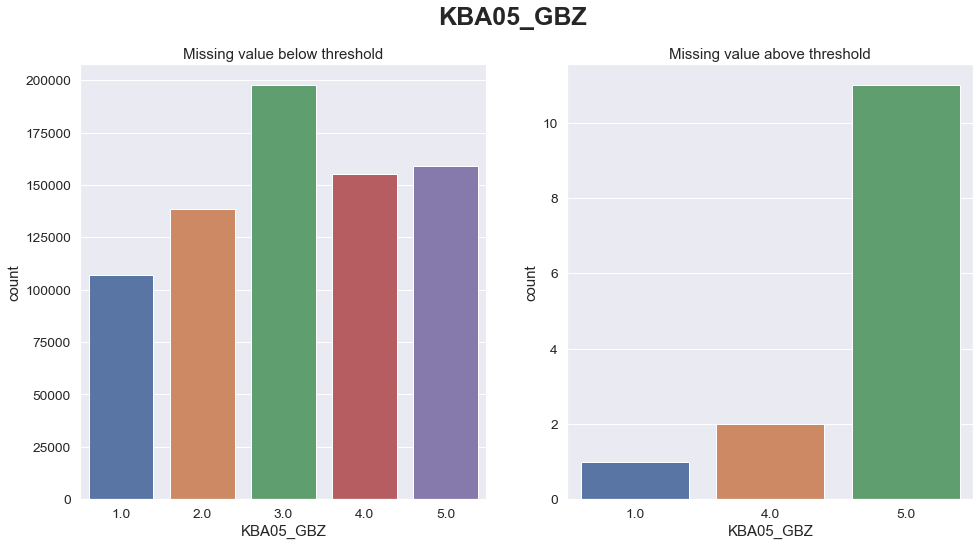

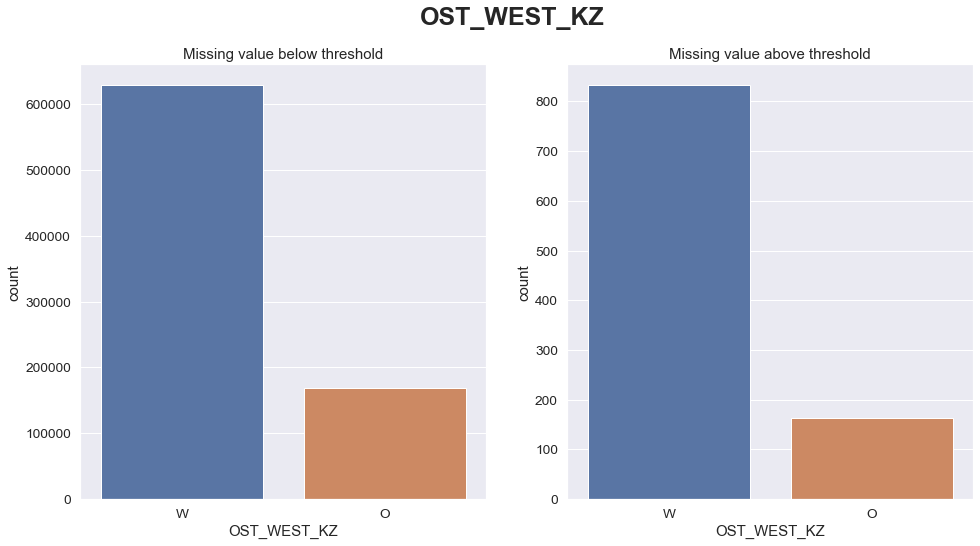

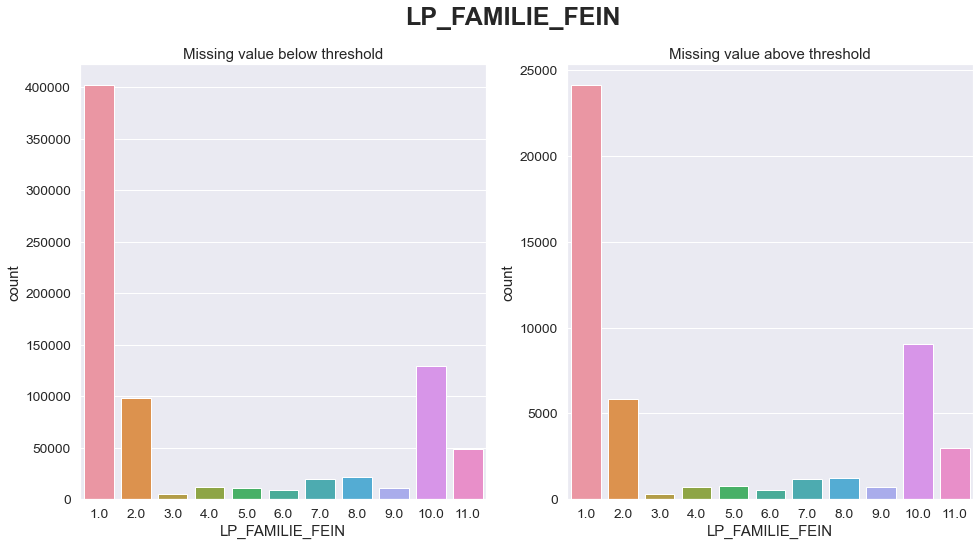

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# The function will compare the column between two dataframes
def compare_cols(col, data1 , data2):
    sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")
    sns.set(rc={'figure.figsize':(16,8)},font_scale=1.25)
    fig, axes = plt.subplots(1,2)
    fig.suptitle(col,fontweight="bold", fontsize=25)
    axes[0].title.set_text('Missing value below threshold')
    sns.countplot(data1[col], ax=axes[0])
    axes[1].title.set_text('Missing value above threshold')
    sns.countplot(data2[col], ax=axes[1])
    return display(fig)

col_list = ['W_KEIT_KIND_HH','KBA05_ANTG4','KBA05_GBZ','OST_WEST_KZ','LP_FAMILIE_FEIN']
data1 = azdias_lt_25
data2 = azdias_gt_25
for col in col_list:
    compare_cols(col, data1 , data2)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

    --> The data is divided between two sets, one with missing values less than 25% in a row and the records with missing value % greater than 25%
    --> The first set has 797077 records whuch is 89.44% of total records
    --> There are only 10.56% records with missing values greated than 25%
    
    

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
# How many features are there of each data type?

azdias_lt_25.head()
print(outliers)
print(feat_info.shape)

# remove the outliers
#feat_info_2 = feat_info[-feat_info.attribute.isin(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'])]
feat_info_2 = feat_info[-feat_info.attribute.isin(outliers)]


print(feat_info_2.shape)
feat_info_2.head()

feat_info_2.groupby(['type'])["attribute"].count()


#Ref: https://stackoverflow.com/questions/19960077/how-to-filter-pandas-dataframe-using-in-and-not-in-like-in-sql


['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
(85, 4)
(79, 4)


type
categorical    18
mixed           6
numeric         6
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_col = feat_info_2[feat_info_2["type"] == "categorical"]
cat_col_name = cat_col.attribute
print('categorial columns are:\n', cat_col_name)

print('unique values for each categorical col\n', azdias_2[cat_col_name].nunique())
cat_binary = []
cat_multi = []
binary = 0
multi = 0

#binary features will have two unique values
for i in cat_col_name:
    if azdias_2[i].nunique() == 2:
        cat_binary.append(i)
        binary+=1
    else:
        cat_multi.append(i)
        multi+=1
print('{} binary categorial columns are:\n{}'.format(binary,cat_binary))
print('{} multi - level categorial columns are:\n{}'.format(multi,cat_multi))



categorial columns are:
 2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object
unique values for each categorical col
 ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64
5 binary categorial columns are:
['ANREDE_KZ', 'GREEN_AVANTGARD

In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.
for i in cat_binary:
    #print('Unique values for {} : {}'.format(i,azdias_2[i].unique()))
    print('Unique values for {} : \n{}\n'.format(i,azdias_2[i].value_counts()))

# For OST_WEST_KZ the unique values are alphabetical, so we can create dummy variable or replace W with 0 and O with 1 as datatype is int
# perform operations on azdias_lt_25 and azdias_gt_25

azdias_lt_25.loc[:,'OST_WEST_KZ'].replace({'W':0,'O':1}, inplace=True)
azdias_gt_25.loc[:,'OST_WEST_KZ'].replace({'W':0,'O':1}, inplace=True)
azdias_2.loc[:,'OST_WEST_KZ'].replace({'W':0,'O':1}, inplace=True)

for i in cat_binary:
    print('New Unique values for {} : \n{}\n'.format(i,azdias_2[i].value_counts()))


Unique values for ANREDE_KZ : 
2    465305
1    425916
Name: ANREDE_KZ, dtype: int64

Unique values for GREEN_AVANTGARDE : 
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64

Unique values for SOHO_KZ : 
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64

Unique values for VERS_TYP : 
2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64

Unique values for OST_WEST_KZ : 
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64



/Users/pp/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


New Unique values for ANREDE_KZ : 
2    465305
1    425916
Name: ANREDE_KZ, dtype: int64

New Unique values for GREEN_AVANTGARDE : 
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64

New Unique values for SOHO_KZ : 
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64

New Unique values for VERS_TYP : 
2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64

New Unique values for OST_WEST_KZ : 
0.0    629528
1.0    168545
Name: OST_WEST_KZ, dtype: int64



In [23]:
# As mentioned in For multi-level categoricals (three or more values), 
#you can choose to encode the values using multiple dummy variables (e.g. via OneHotEncoder), or (to keep things straightforward) 
#just drop them from the analysis. As always, document your choices in the Discussion section.

#print('unique values for each categorical col', azdias_2[cat_col_name].nunique())

# I decide to drop columns with categorical values greater than 10 for my analysis. I will review the results again without dropping all of them
multi_drop = []
for i in cat_multi:
    print('Unique values for {} : {}\n'.format(i,azdias_2[i].nunique()))
    if azdias_2[i].nunique() >10:
        multi_drop.append(i)
multi_drop

Unique values for CJT_GESAMTTYP : 6

Unique values for FINANZTYP : 6

Unique values for GFK_URLAUBERTYP : 12

Unique values for LP_FAMILIE_FEIN : 11

Unique values for LP_FAMILIE_GROB : 5

Unique values for LP_STATUS_FEIN : 10

Unique values for LP_STATUS_GROB : 5

Unique values for NATIONALITAET_KZ : 3

Unique values for SHOPPER_TYP : 4

Unique values for ZABEOTYP : 6

Unique values for GEBAEUDETYP : 7

Unique values for CAMEO_DEUG_2015 : 9

Unique values for CAMEO_DEU_2015 : 44



['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'CAMEO_DEU_2015']

In [24]:

print('---before dropping multi-value features with more than 10 values----')
print('azdias_2 :',azdias_2.shape)
print('azdias_lt_25 :',azdias_lt_25.shape)
print('azdias_gt_25 :',azdias_gt_25.shape)

azdias_encode = azdias_2.drop(multi_drop, axis = 1)
azdias_lt_25_encode = azdias_lt_25.drop(multi_drop, axis = 1)
azdias_gt_25_encode = azdias_gt_25.drop(multi_drop, axis = 1)
feat_info_2 = feat_info_2[-feat_info_2.attribute.isin(multi_drop)]

print('---after dropping multi-value features with more than 10 values----')
print('azdias_encode :',azdias_encode.shape)
print('azdias_lt_25_encode :',azdias_lt_25_encode.shape)
print('azdias_gt_25_encode :',azdias_gt_25_encode.shape)

---before dropping multi-value features with more than 10 values----
azdias_2 : (891221, 79)
azdias_lt_25 : (797077, 79)
azdias_gt_25 : (94144, 79)
---after dropping multi-value features with more than 10 values----
azdias_encode : (891221, 76)
azdias_lt_25_encode : (797077, 76)
azdias_gt_25_encode : (94144, 76)


In [25]:
#cat_multi.remove(multi_drop)

for i in multi_drop:
    try:
        cat_multi.remove(i)
    except ValueError:
        pass
cat_multi


['CJT_GESAMTTYP',
 'FINANZTYP',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015']

In [26]:
#after encoding


azdias_lt_25_fe = pd.get_dummies(azdias_lt_25_encode, columns=cat_multi)
azdias_gt_25_fe = pd.get_dummies(azdias_lt_25_encode, columns=cat_multi)
azdias_encode_fe = pd.get_dummies(azdias_encode, columns=cat_multi)

print('---after final encoding----')
print('azdias_encode_fe :',azdias_encode_fe.shape)
print('azdias_lt_25_encode :',azdias_lt_25_fe.shape)
print('azdias_gt_25_encode :',azdias_gt_25_fe.shape)
print('azdias_encode_fe :',list(azdias_encode_fe.columns))



---after final encoding----
azdias_encode_fe : (891221, 127)
azdias_lt_25_encode : (797077, 127)
azdias_gt_25_encode : (797077, 127)
azdias_encode_fe : ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MO

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

    --> There are 18 categorical variables, 5 binary and 13 multi-value
    --> One of the binary variables, OST_WEST_KZ has two values as 'W' and 'O', which is replaced with 1 and 0
    --> The multi-value categorical features are converted into column values.
    --> Out of 13 multi-value, I decide to drop columns with categorical values greater than 10 for my analysis.
    
            5 binary categorial columns are:
            ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
            13 multi - level categorial columns are:
            ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
import sys
import collections
import itertools

with open('Data_Dictionary.md', 'r') as searchfile:
    before = collections.deque(maxlen=10)
    for line in searchfile:
        if 'PRAEGENDE_JUGENDJAHRE' in line:
            #print(line[10])
            sys.stdout.writelines(before)
            sys.stdout.write(line)
            sys.stdout.writelines(itertools.islice(searchfile, 20))
            break

#Ref: https://stackoverflow.com/questions/36027227/grep-for-a-word-and-if-found-print-10-lines-before-and-10-lines-after-the-patte


### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

### 1.19. RETOURTYP_BK_S


In [28]:
#binary variable for movement
def movement(row):
    if row in (1, 3, 5, 8, 10, 12, 14):
        return 0 # Mainstream
    if row in (2,4,6,7,9,11,13,15):
        return 1 #Avantgarde
    
#interval variable for decade
def decade(row):
    if row in (1,2):
        return 1940
    if row in (3,4):
        return 1950
    if row in (5,6,7):
        return 1960
    if row in (8,9):
        return 1970
    if row in (10,11,12,13):
        return 1980
    if row in (14,15):
        return 1990
    

azdias_encode_fe['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias_encode_fe['PRAEGENDE_JUGENDJAHRE'].apply(movement)
azdias_encode_fe['PRAEGENDE_JUGENDJAHRE_DEC'] = azdias_encode_fe['PRAEGENDE_JUGENDJAHRE'].apply(decade)

#Ref: https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o 



In [29]:
print(azdias_encode_fe['PRAEGENDE_JUGENDJAHRE_MOV'].value_counts())
print(azdias_encode_fe['PRAEGENDE_JUGENDJAHRE_DEC'].value_counts())
azdias_encode_fe.shape

0.0    607832
1.0    175225
Name: PRAEGENDE_JUGENDJAHRE_MOV, dtype: int64
1990.0    231244
1970.0    179558
1980.0    151770
1960.0    116078
1950.0     75646
1940.0     28761
Name: PRAEGENDE_JUGENDJAHRE_DEC, dtype: int64


(891221, 129)

In [30]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
import sys
import collections
import itertools

with open('Data_Dictionary.md', 'r') as searchfile:
    before = collections.deque(maxlen=10)
    for line in searchfile:
        if 'CAMEO_INTL_2015' in line:
            #print(line[10])
            sys.stdout.writelines(before)
            sys.stdout.write(line)
            sys.stdout.writelines(itertools.islice(searchfile, 35))
            break

#Ref: https://stackoverflow.com/questions/36027227/grep-for-a-word-and-if-found-print-10-lines-before-and-10-lines-after-the-patte

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affl

In [31]:
print('****************\n',azdias_encode_fe['CAMEO_INTL_2015'].isna().value_counts())

****************
 False    791869
True      99352
Name: CAMEO_INTL_2015, dtype: int64


In [32]:
azdias_encode_fe['CAMEO_INTL_2015'] = pd.to_numeric(azdias_encode_fe['CAMEO_INTL_2015'])
#print(azdias_encode_fe.CAMEO_INTL_2015.astype(str).str[0])
print(azdias_encode_fe.shape)

azdias_encode_fe.head().T
#azdias_encode_fe = azdias_encode_fe.drop(['CAMEO_INTL_15_WEALTH','CAMEO_INTL_15_LIFE_STAGE'], axis = 1)



(891221, 129)


,0,1,2,3,4
ALTERSKATEGORIE_GROB,2.0,1.0,3.0,4.0,3.0
ANREDE_KZ,1.0,2.0,2.0,2.0,1.0
FINANZ_MINIMALIST,3.0,1.0,1.0,4.0,4.0
FINANZ_SPARER,4.0,5.0,4.0,2.0,3.0
FINANZ_VORSORGER,3.0,2.0,1.0,5.0,4.0
FINANZ_ANLEGER,5.0,5.0,2.0,2.0,1.0
FINANZ_UNAUFFAELLIGER,5.0,4.0,3.0,1.0,3.0
FINANZ_HAUSBAUER,3.0,5.0,5.0,2.0,2.0
GREEN_AVANTGARDE,0.0,0.0,1.0,0.0,0.0
HEALTH_TYP,NaN,3.0,3.0,2.0,3.0


In [33]:
print(azdias_encode_fe.shape)

(891221, 129)


In [34]:
count = 0
CAMEO_INTL_15_WEALTH = []
CAMEO_INTL_15_LIFE_STAGE = []
for i in azdias_encode_fe['CAMEO_INTL_2015']:
    if pd.isna(i):
        count+=1
        CAMEO_INTL_15_WEALTH.append(i)
        CAMEO_INTL_15_LIFE_STAGE.append(i)
    else:
        CAMEO_INTL_15_WEALTH.append(int(str(i)[0]))
        CAMEO_INTL_15_LIFE_STAGE.append(int(str(i)[1]))
azdias_encode_fe['CAMEO_INTL_15_WEALTH'] = CAMEO_INTL_15_WEALTH
azdias_encode_fe['CAMEO_INTL_15_LIFE_STAGE'] = CAMEO_INTL_15_LIFE_STAGE
print('total NaN values on CAMEO_INTL_2015 is:', count)
print(azdias_encode_fe['CAMEO_INTL_15_WEALTH'].value_counts())
print(azdias_encode_fe['CAMEO_INTL_15_LIFE_STAGE'].value_counts())
azdias_encode_fe.shape


total NaN values on CAMEO_INTL_2015 is: 99352
5.0    223582
2.0    190691
4.0    189960
1.0    119443
3.0     68193
Name: CAMEO_INTL_15_WEALTH, dtype: int64
1.0    245054
4.0    232777
3.0    119693
5.0    117045
2.0     77300
Name: CAMEO_INTL_15_LIFE_STAGE, dtype: int64


(891221, 131)

In [35]:
print(type(outliers), outliers)

#print(feat_info_2.groupby(['type'])["attribute"].count())
mixed_drop = []
mixed_drop.append(feat_info[feat_info.type == 'mixed']['attribute'].values.tolist())
#print('mixed1-------\n',mixed1)
print(type(mixed_drop), mixed_drop[0])

for i in outliers:
    try:
        mixed_drop[0].remove(i)
    except ValueError:

        pass
#mixed_drop[0]

#azdias_encode_fe = azdias_encode_fe.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_FEIN','PRAEGENDE_JUGENDJAHRE','WOHNLAGE','CAMEO_INTL_2015','PLZ8_BAUMAX'], axis = 1)
azdias_encode_fe = azdias_encode_fe.drop(mixed_drop[0], axis = 1)
#print(azdias_encode_fe.shape)




<class 'list'> ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
<class 'list'> ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


In [36]:
azdias_encode_fe.head().T
# remove the outliers
#feat_info_2 = feat_info[-feat_info.attribute.isin(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_FEIN','PRAEGENDE_JUGENDJAHRE','WOHNLAGE','CAMEO_INTL_2015','PLZ8_BAUMAX'])]
feat_info_2 = feat_info_2[-feat_info_2.attribute.isin(mixed_drop[0])]
print(feat_info_2.shape)
feat_info_2.head()

feat_info_2.groupby(['type'])["attribute"].count()
feat_info.head()


(70, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

    --> There are 6 mixed features and out of which two variables were investigated and engineered
    --> Dropped all the original mixed variables 
    --> The CAMEO_INTL_2015 has NaN values, so need to convert into numeric first and then split and populated into new columns, ten's as _WEALTH and ones into _LIFE_STAGE


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [37]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [38]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_encode_fe.shape

(891221, 125)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i,j in enumerate(feat_info['attribute'].values):
        miss_or_unk = feat_info[feat_info.attribute==j]['missing_or_unknown'].values
        for i in range(len(miss_or_unk)):
            miss_or_unk[i] = miss_or_unk[i].strip('[]').split(',')
        for i in range(len(miss_or_unk[0])):
            if miss_or_unk[0][i]!='X' and miss_or_unk[0][i]!='XX' and miss_or_unk[0][i]!='' and miss_or_unk[0][i] != ['']:
                miss_or_unk[0][i] = int(miss_or_unk[0][i])
            else:
                miss_or_unk[0] = miss_or_unk[0][i]
        df[j] = df[j].replace(miss_or_unk[0], np.nan)
    
    azdias = df.copy()
    # remove selected columns and rows, ...
    # Investigate patterns in the amount of missing data in each column.
    # select, re-encode, and engineer column values.
    azdias.loc[:,'OST_WEST_KZ'].replace({'W':0,'O':1}, inplace=True)
    outliers = []
    count1 = 0
    count2 = 0
    count3 = 0
    count4 = 0
    for i,j in enumerate(feat_info['attribute'].values):
        miss = (azdias[j].isnull().sum()/azdias.shape[0])*100
        if miss < 25:
            count1+=1
        elif 25 < miss < 50:
            count2+=1
            outliers.append(j)
        elif 50 < miss < 75:
            count3+=1
            outliers.append(j)
        else:
            count4+=1
            outliers.append(j)
    '''print('*******--------------outliers*******--------------',outliers)
    print('{} of features has missing data less than 25%:'.format(count1))
    print('{} of features has missing data btw 25 and 50%:'.format(count2))
    print('{} of features has missing data btw 50 and 75%:'.format(count3))
    print('{} of features has missing data more than 75%'.format(count3))
    '''
    engg_elements = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']
    for i in engg_elements:
        try:
            outliers.remove(i)
        except ValueError:
            pass
    outliers
    azdias_2 = azdias.drop(outliers, axis = 1)
    feat_info_2 = feat_info[-feat_info.attribute.isin(outliers)]
    
    
    cat_binary = []
    cat_multi = []
    binary = 0
    multi = 0
    
    cat_col = feat_info_2[feat_info_2["type"] == "categorical"]
    cat_col_name = cat_col.attribute
    #binary features will have two unique values
    for i in cat_col_name:
        if azdias_2[i].nunique() == 2:
            cat_binary.append(i)
            binary+=1
        else:
            cat_multi.append(i)
            multi+=1
    
            multi_drop = []
        for i in cat_multi:
            #print('Unique values for {} : {}\n'.format(i,azdias_2[i].nunique()))
            if azdias_2[i].nunique() >10:
                multi_drop.append(i)
    #print('*******--------------multi_drop*******--------------',multi_drop)
    azdias_encode = azdias_2.drop(multi_drop, axis = 1)
    feat_info_2 = feat_info_2[-feat_info_2.attribute.isin(multi_drop)]
    for i in multi_drop:
        try:
            cat_multi.remove(i)
        except ValueError:
            pass
    cat_multi
    azdias_encode_fe = pd.get_dummies(azdias_encode, columns=cat_multi)
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

    with open('Data_Dictionary.md', 'r') as searchfile:
        before = collections.deque(maxlen=10)
        for line in searchfile:
            if 'PRAEGENDE_JUGENDJAHRE' in line:
                #print(line[10])
                #sys.stdout.writelines(before)
                #sys.stdout.write(line)
                #sys.stdout.writelines(itertools.islice(searchfile, 20))
                break
    
    #binary variable for movement
    def movement(row):
        if row in (1, 3, 5, 8, 10, 12, 14):
            return 0 # Mainstream
        if row in (2,4,6,7,9,11,13,15):
            return 1 #Avantgarde
        
    #interval variable for decade
    def decade(row):
        if row in (1,2):
            return 1940
        if row in (3,4):
            return 1950
        if row in (5,6,7):
            return 1960
        if row in (8,9):
            return 1970
        if row in (10,11,12,13):
            return 1980
        if row in (14,15):
            return 1990
        
    
    azdias_encode_fe['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias_encode_fe['PRAEGENDE_JUGENDJAHRE'].apply(movement)
    azdias_encode_fe['PRAEGENDE_JUGENDJAHRE_DEC'] = azdias_encode_fe['PRAEGENDE_JUGENDJAHRE'].apply(decade)

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    with open('Data_Dictionary.md', 'r') as searchfile:
        before = collections.deque(maxlen=10)
        for line in searchfile:
            if 'CAMEO_INTL_2015' in line:
                #print(line[10])
                #sys.stdout.writelines(before)
                #sys.stdout.write(line)
                #sys.stdout.writelines(itertools.islice(searchfile, 35))
                break
    azdias_encode_fe['CAMEO_INTL_2015'] = pd.to_numeric(azdias_encode_fe['CAMEO_INTL_2015'])
    #print(azdias_encode_fe.shape)
    
    count = 0
    CAMEO_INTL_15_WEALTH = []
    CAMEO_INTL_15_LIFE_STAGE = []
    for i in azdias_encode_fe['CAMEO_INTL_2015']:
        if pd.isna(i):
            count+=1
            CAMEO_INTL_15_WEALTH.append(i)
            CAMEO_INTL_15_LIFE_STAGE.append(i)
        else:
            CAMEO_INTL_15_WEALTH.append(int(str(i)[0]))
            CAMEO_INTL_15_LIFE_STAGE.append(int(str(i)[1]))
    azdias_encode_fe['CAMEO_INTL_15_WEALTH'] = CAMEO_INTL_15_WEALTH
    azdias_encode_fe['CAMEO_INTL_15_LIFE_STAGE'] = CAMEO_INTL_15_LIFE_STAGE

    
    mixed_drop = []
    mixed_drop.append(feat_info_2[feat_info_2.type == 'mixed']['attribute'].values.tolist())
    for i in outliers:
        try:
            mixed_drop[0].remove(i)
        except ValueError:    
            pass
    #print('*******--------------mixed_drop*******--------------',mixed_drop)
    azdias_encode_fe = azdias_encode_fe.drop(mixed_drop[0], axis = 1)
    feat_info_2 = feat_info_2[-feat_info_2.attribute.isin(mixed_drop[0])]

    # Return the cleaned dataframe.
    return azdias_encode_fe, feat_info_2

In [40]:
azdias_val = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv',sep=';')
azdias_clean, feat_info_clean = clean_data(azdias_val)


In [41]:
azdias_clean.shape
#feat_info_clean.shape

(891221, 125)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [42]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#total Nan values in all the columns
azdias_clean_copy = azdias_clean.copy()
print(azdias_clean_copy.isnull().sum().sum())
print(azdias_clean_copy.shape)

print('*****removing all the data points with missing values')
azdias_drop_nan = azdias_clean_copy.dropna(axis = 0)
print(azdias_drop_nan.isnull().sum().sum())
print(azdias_drop_nan.shape)

4154590
(891221, 125)
*****removing all the data points with missing values
0
(623211, 125)


In [43]:
print(feat_info_clean.shape)
feat_info_clean.head()
azdias_clean_copy2 = azdias_clean.copy()
azdias_clean_copy2.head()
print(azdias_clean_copy2.shape)

(70, 4)
(891221, 125)


In [44]:
unique_val = []
for col in azdias_clean_copy2.columns: 
    #print(col,'----',azdias_clean_copy2[col].unique())
    unique_val.append(azdias_clean_copy2[col].unique().tolist())
unique_val
#unique(unique_val)


[[2.0, 1.0, 3.0, 4.0, nan],
 [1, 2],
 [3, 1, 4, 2, 5],
 [4, 5, 2, 3, 1],
 [3, 2, 1, 5, 4],
 [5, 2, 1, 4, 3],
 [5, 4, 3, 1, 2],
 [3, 5, 2, 4, 1],
 [0, 1],
 [nan, 3.0, 2.0, 1.0],
 [5.0, 1.0, 3.0, 2.0, 4.0, nan],
 [2, 5, 4, 6, 7, 3, 1],
 [6, 4, 1, 5, 7, 2, 3],
 [7, 4, 3, 2, 5, 1, 6],
 [5, 3, 1, 2, 4, 7, 6],
 [1, 4, 7, 2, 6, 5, 3],
 [5, 2, 4, 6, 7, 3, 1],
 [3, 2, 6, 7, 4, 5, 1],
 [3, 4, 6, 5, 7, 1, 2],
 [4, 6, 3, 2, 7, 5, 1],
 [7, 4, 3, 1, 5, 6, 2],
 [6, 7, 4, 2, 1, 5, 3],
 [6, 4, 7, 5, 2, 3, 1],
 [5, 7, 3, 4, 1, 6, 2],
 [3, 6, 4, 2, 7, 5, 1],
 [nan, 1.0, 0.0],
 [nan, 2.0, 1.0],
 [nan,
  2.0,
  1.0,
  0.0,
  4.0,
  3.0,
  5.0,
  7.0,
  6.0,
  8.0,
  12.0,
  9.0,
  21.0,
  10.0,
  13.0,
  11.0,
  14.0,
  45.0,
  20.0,
  31.0,
  29.0,
  37.0,
  16.0,
  22.0,
  15.0,
  23.0,
  18.0,
  35.0,
  17.0,
  40.0,
  38.0],
 [nan, 0.0, 1.0, 2.0, 4.0, 3.0, 6.0],
 [2.0, 6.0, 4.0, 1.0, 5.0, 3.0, nan],
 [nan, 3.0, 2.0, 6.0, 5.0, 4.0, 1.0],
 [nan, 9.0, 8.0, 3.0, 4.0, 5.0, 6.0, 2.0, 7.0, 1.0],
 [nan,
  11.0

In [45]:
# Apply feature scaling to the general population demographics data.
#from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(azdias_drop_nan) 
print(scaler.fit(azdias_drop_nan))
print(scaler.mean_)
print(scaler.transform(azdias_drop_nan))

StandardScaler()
[2.79253896e+00 1.51121049e+00 3.05779904e+00 2.67700987e+00
 3.45143459e+00 2.77021426e+00 2.56309179e+00 3.16959425e+00
 2.34626796e-01 2.20748511e+00 3.42276372e+00 4.24180895e+00
 4.07886575e+00 3.90041575e+00 3.82569146e+00 4.27591458e+00
 4.31958037e+00 4.57232141e+00 4.17690638e+00 3.85675317e+00
 4.50838961e+00 4.59847307e+00 4.25811643e+00 4.13192322e+00
 3.73595460e+00 8.49792446e-03 1.53228361e+00 1.80822546e+00
 4.14947746e-03 4.52867809e+00 4.19643748e+00 7.96662447e+00
 8.44135132e+00 3.97826739e-02 2.96383408e+00 1.99253470e+03
 2.12335790e-01 1.50626995e+00 1.27757533e+00 6.33265459e-01
 3.00076539e-01 3.14943093e+00 4.09333115e+00 4.02269697e+00
 4.48601838e+00 3.72771341e+00 2.72853656e+00 2.96608372e+00
 2.74540084e+00 4.47265372e+00 6.11896683e+02 2.22908935e+00
 2.83258800e+00 1.63179244e+00 7.18528717e-01 3.61471155e+00
 3.35043829e+00 3.19900162e+00 5.39450363e+00 3.11306925e+00
 1.17082336e-01 1.81646344e-01 1.90952984e-01 2.58191848e-01
 1.2813

In [79]:
# Apply feature scaling to the general population demographics data.

print('*****removing all the data points using imputer')
# define the imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_fit_trans = imp_mean.fit_transform(azdias_clean_copy2)

#transformed_values = imputer.fit_transform(azdias_clean_copy2)
#scaler.fit(imp_tran) 
azdias_scaling = scaler.fit_transform(imp_fit_trans)
#print(scaler.fit_transform(imp_fit_trans))
#Ref: https://machinelearningmastery.com/handle-missing-data-python/

*****removing all the data points using imputer


array([[2.00000000e+00, 1.00000000e+00, 3.00000000e+00, ...,
        1.97332805e+03, 3.26209764e+00, 2.87303329e+00],
       [1.00000000e+00, 2.00000000e+00, 1.00000000e+00, ...,
        1.99000000e+03, 5.00000000e+00, 1.00000000e+00],
       [3.00000000e+00, 2.00000000e+00, 1.00000000e+00, ...,
        1.99000000e+03, 2.00000000e+00, 4.00000000e+00],
       ...,
       [2.00000000e+00, 2.00000000e+00, 2.00000000e+00, ...,
        1.99000000e+03, 2.00000000e+00, 4.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.99000000e+03, 5.00000000e+00, 1.00000000e+00],
       [4.00000000e+00, 1.00000000e+00, 4.00000000e+00, ...,
        1.95000000e+03, 4.00000000e+00, 3.00000000e+00]])

In [47]:
#azdias_scaling_df = pd.DataFrame(azdias_scaling, columns=list(azdias_scaling))
#azdias_scaling_df.head()
#print('*****after imputing*****')
#print(azdias_scaling_df.isnull().sum().sum())
#print(azdias_scaling_df.shape)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

    --> There are total 4154590 NaN values in the cleaned dataframe 
    --> Records rediced from 891221 to 623211 after droppig the NaN records, which is equivalent to 30% of total records
    --> dropping null records is not a preferable method, hence imputing the records with strategy as mean will allow us to keep the records

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [49]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
print(azdias_scaling.shape)
pca = PCA(n_components=65) #50% of imputed and scaled output
X_pca = pca.fit_transform(azdias_scaling) # review comment
#X_pca = pca.transform(azdias_scaling)


(891221, 125)


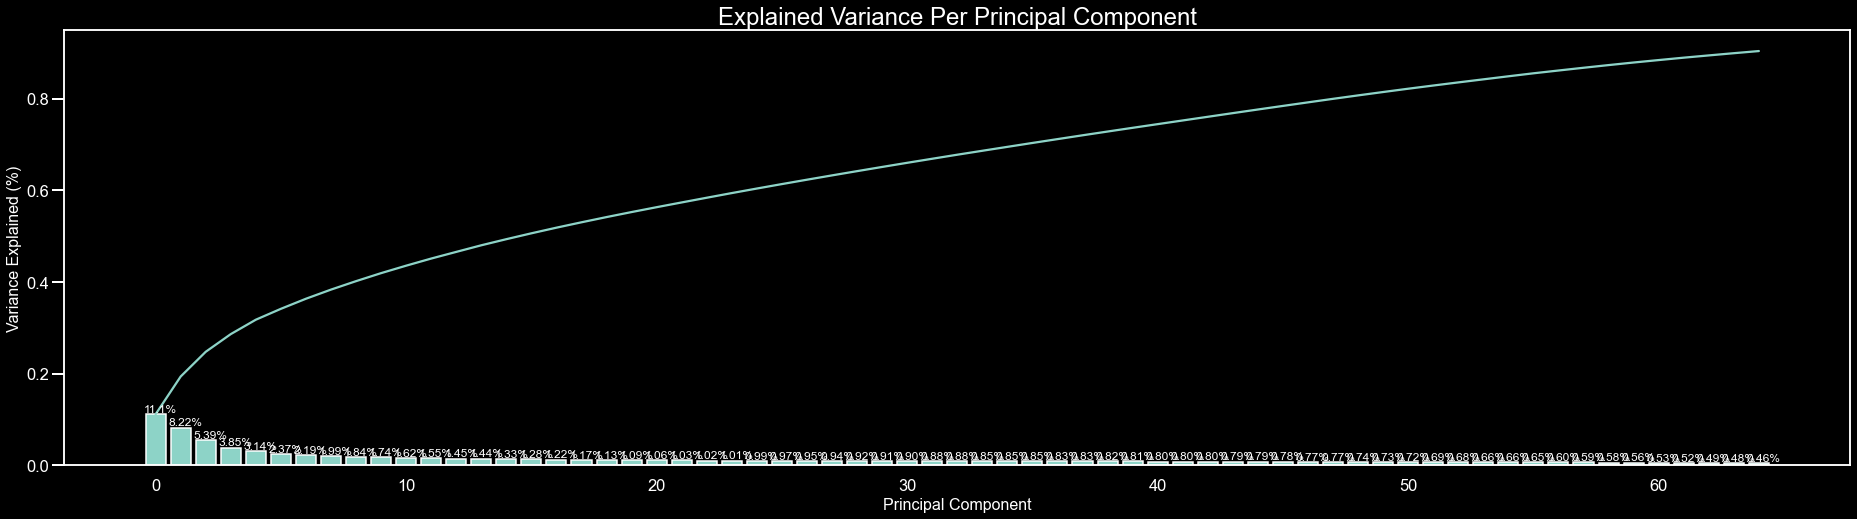

In [50]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")
    plt.figure(figsize=(32, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_xlabel("Principal Component",fontsize=16)
    ax.set_ylabel("Variance Explained (%)",fontsize=16)
    plt.title('Explained Variance Per Principal Component', fontsize=24)
scree_plot(pca)

In [51]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    #X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data) # review comment
    #X_pca = pca.transform(data)
    return pca, X_pca



In [52]:
#for comp in range(2, azdias_scaling.shape[1]):
for comp in range(2, azdias_scaling.shape[1]):
    pca, X_pca = do_pca(comp, azdias_scaling)
    #print("With  {} components, explained variance is {}.".format(comp, pca.explained_variance_ratio_.sum()))
    if(pca.explained_variance_ratio_.sum()>.70):
        pca_final = pca.explained_variance_ratio_.sum()
        final_comp = comp
        break
print('\n\n Variance of {:.4f}% is achieved with {} components, Reapply the PCA'.format((pca.explained_variance_ratio_.sum())*100,final_comp))





 Variance of 70.8756% is achieved with 37 components, Reapply the PCA


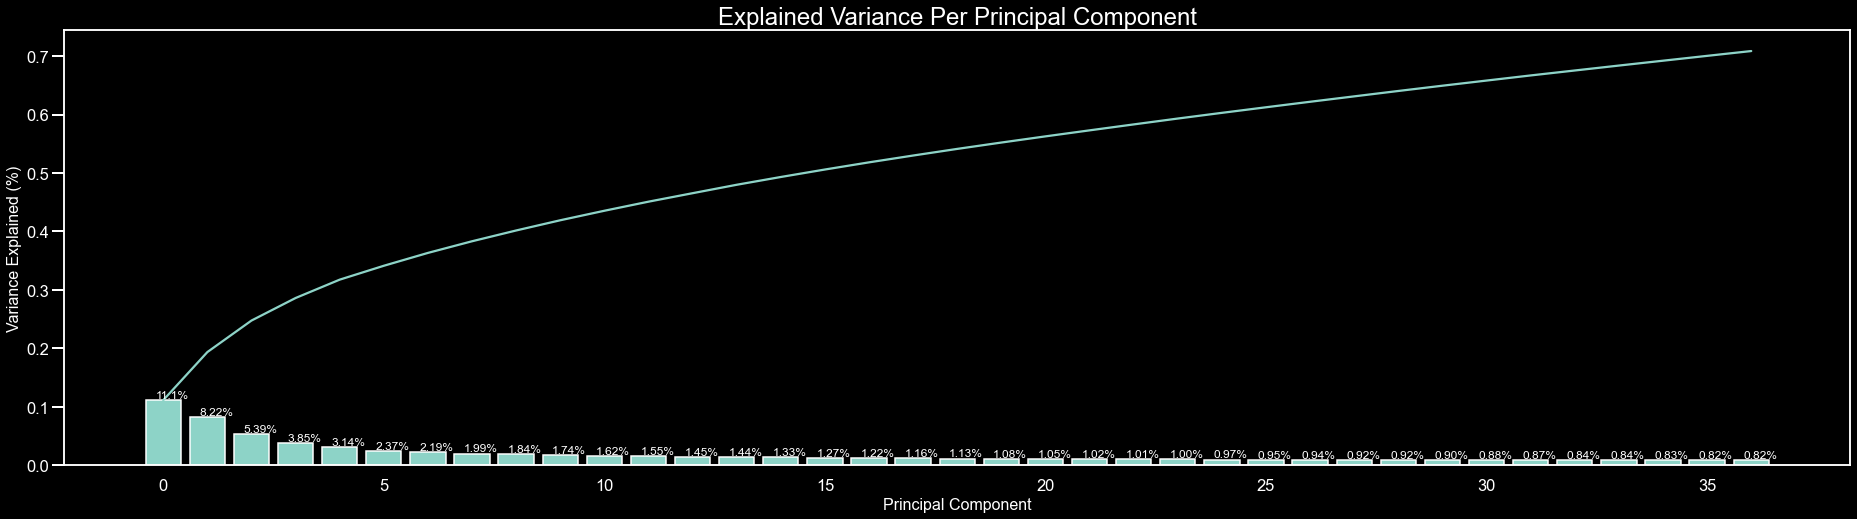

In [53]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_final, X_pca_final = do_pca(final_comp, azdias_scaling)
scree_plot(pca_final)


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

    --> Variance is 50% with only 16 components and 90% with 65 components
    --> The Explained variance per Proncipal component curve growth becomes almost stagnant after 25-30 components
    --> I decide to proceed with 31 components  with total variance of 65%



### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
pca_final_gen, X_pca_final_gen = do_pca(31, azdias_scaling)
print(X_pca_final_gen.shape)
print(len(pca_final_gen.components_))

(891221, 31)
31


In [55]:
dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca_final_gen.components_)+1)]
components = pd.DataFrame(pca.components_,  columns = azdias_clean_copy2.keys())
components = components.iloc[1-1,:]
components = components.sort_values(ascending=False)
components = components.to_frame()
top_5 = components.head(5)
low_5 = components.tail(5)
#low_5 = low_5.reset_index(drop=True)
comp_df = pd.concat([top_5, low_5], axis=0)
comp_df.head(10)

,0
LP_STATUS_GROB_1.0,0.195948
PLZ8_ANTG3,0.190618
CAMEO_INTL_15_WEALTH,0.187293
PLZ8_ANTG4,0.184798
HH_EINKOMMEN_SCORE,0.165862
KBA05_GBZ,-0.189738
PLZ8_ANTG1,-0.190642
KBA05_ANTG1,-0.199073
FINANZ_MINIMALIST,-0.203292
MOBI_REGIO,-0.212606


In [56]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

pca_final_gen, X_pca_final_gen = do_pca(31, azdias_scaling)

def pca_results(full_dataset, pca, comp):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns=full_dataset.keys()).iloc[comp-1,:].sort_values(ascending=False)
    components = components.to_frame()
    top_5 = components.head(5)
    low_5 = components.tail(5)
    #low_5 = low_5.reset_index(drop=True)
    comp_df = pd.concat([top_5, low_5], axis=0)
    #components.index = dimensions
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    plt.figure(figsize=(12, 8))
    plt.suptitle("Interpret Principal Component {}".format(comp))  
    comp_df.plot(kind = 'bar', fontsize = 14)

    # Return a concatenated DataFrame
    return comp_df

#Ref: https://www.weirdgeek.com/2018/11/plotting-multiple-bar-graph/

,1
ALTERSKATEGORIE_GROB,0.2341
FINANZ_VORSORGER,0.2255
SEMIO_ERL,0.1831
ZABEOTYP_3,0.1623
RETOURTYP_BK_S,0.1616
SEMIO_REL,-0.2167
FINANZ_ANLEGER,-0.2172
FINANZ_UNAUFFAELLIGER,-0.2243
FINANZ_SPARER,-0.2347
PRAEGENDE_JUGENDJAHRE_DEC,-0.2381


<Figure size 864x576 with 0 Axes>

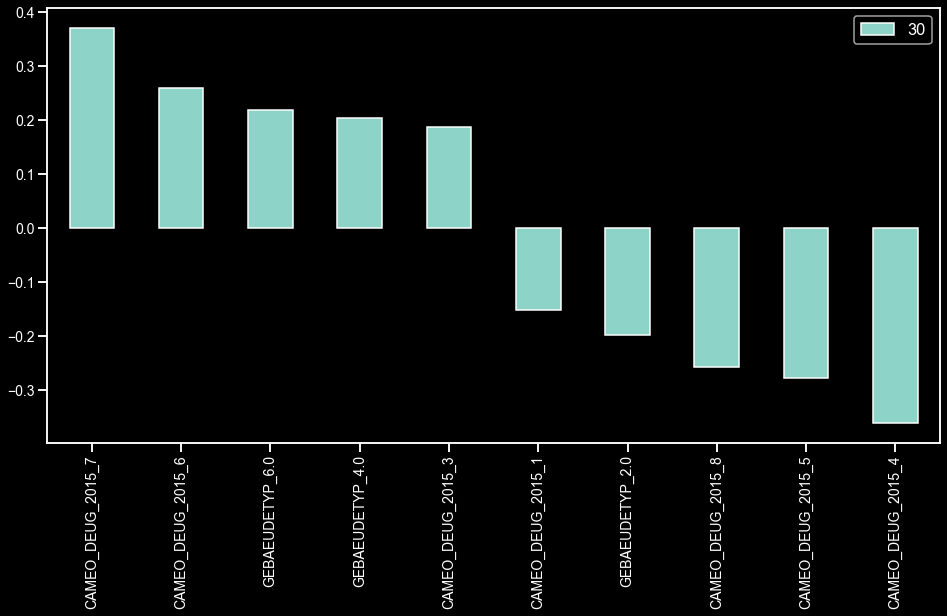

<Figure size 864x576 with 0 Axes>

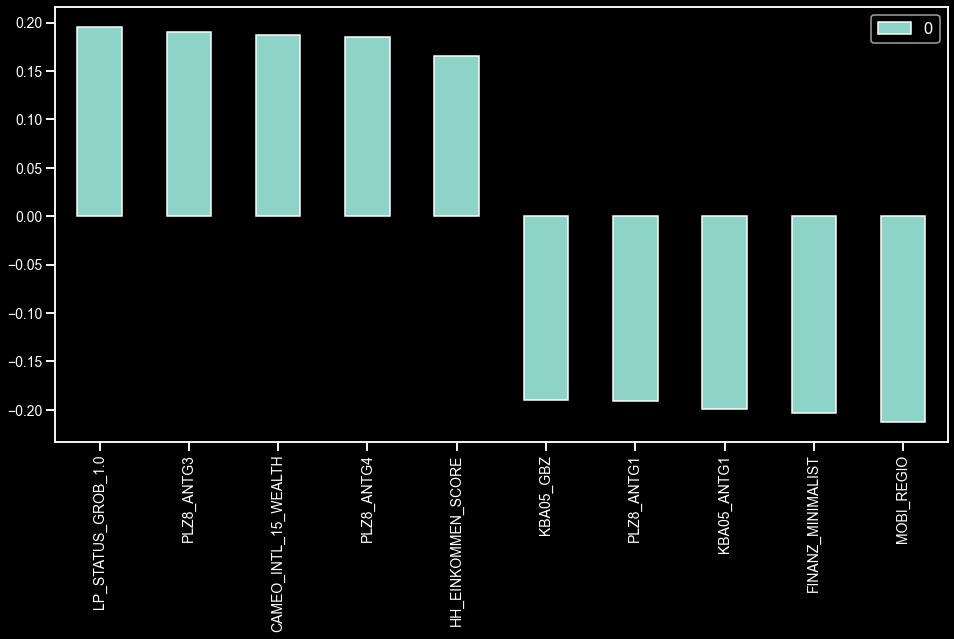

<Figure size 864x576 with 0 Axes>

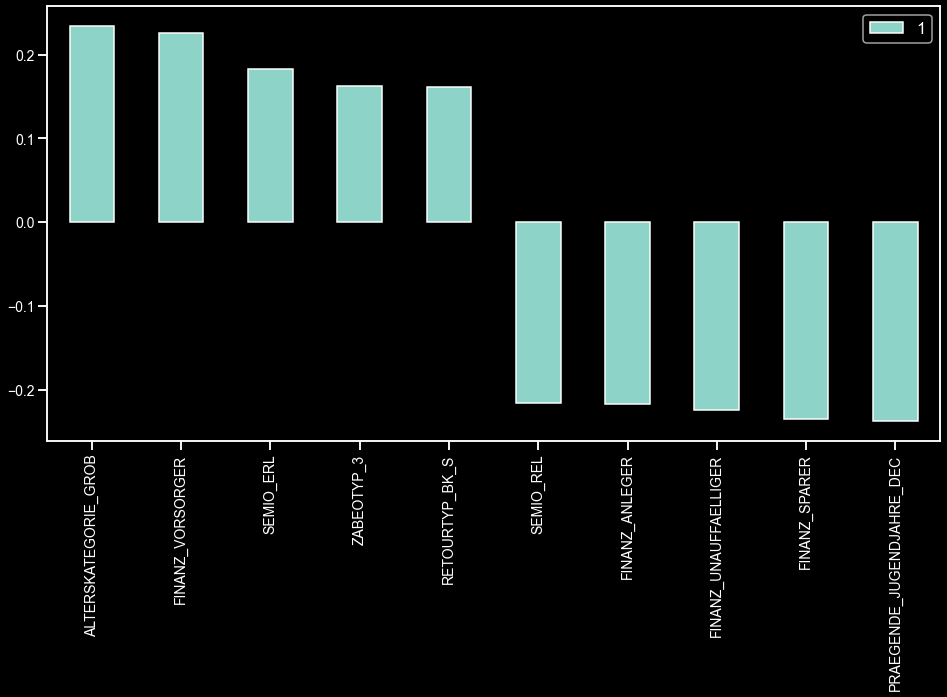

In [57]:
for i in range(3):
    comp_df = pca_results(azdias_clean_copy2, pca_final_gen, i)
comp_df

Interpret Principal Component 1
---------positive & negative variance features---------                        30
CAMEO_DEUG_2015_7  0.3720
CAMEO_DEUG_2015_6  0.2608
GEBAEUDETYP_6.0    0.2190
GEBAEUDETYP_4.0    0.2051
CAMEO_DEUG_2015_3  0.1884
CAMEO_DEUG_2015_1 -0.1518
GEBAEUDETYP_2.0   -0.1984
CAMEO_DEUG_2015_8 -0.2575
CAMEO_DEUG_2015_5 -0.2774
CAMEO_DEUG_2015_4 -0.3610
Interpret Principal Component 2
---------positive & negative variance features---------                            0
LP_STATUS_GROB_1.0    0.1959
PLZ8_ANTG3            0.1906
CAMEO_INTL_15_WEALTH  0.1873
PLZ8_ANTG4            0.1848
HH_EINKOMMEN_SCORE    0.1659
KBA05_GBZ            -0.1897
PLZ8_ANTG1           -0.1906
KBA05_ANTG1          -0.1991
FINANZ_MINIMALIST    -0.2033
MOBI_REGIO           -0.2126
Interpret Principal Component 3
---------positive & negative variance features---------                                 1
ALTERSKATEGORIE_GROB       0.2341
FINANZ_VORSORGER           0.2255
SEMIO_ERL                  0.

<Figure size 864x576 with 0 Axes>

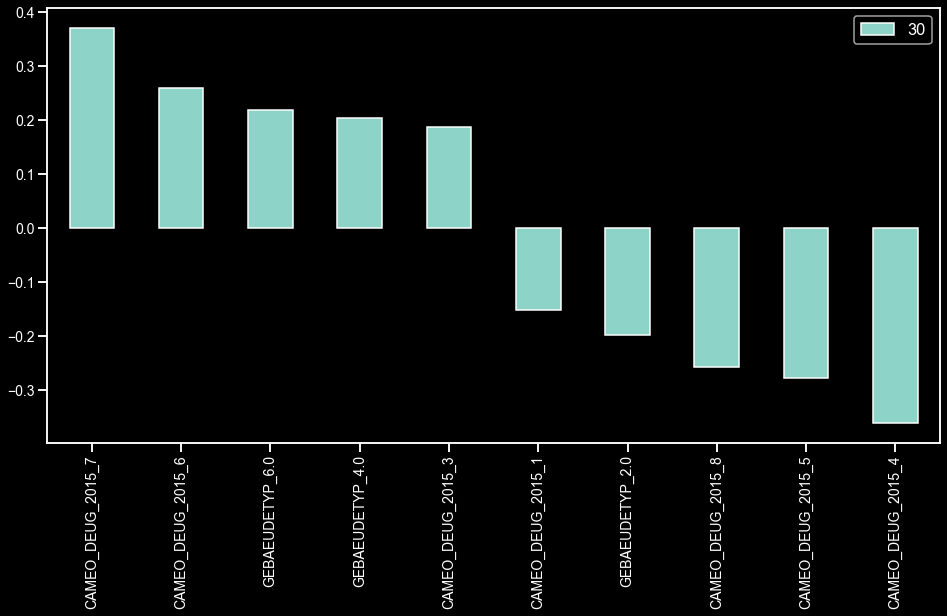

<Figure size 864x576 with 0 Axes>

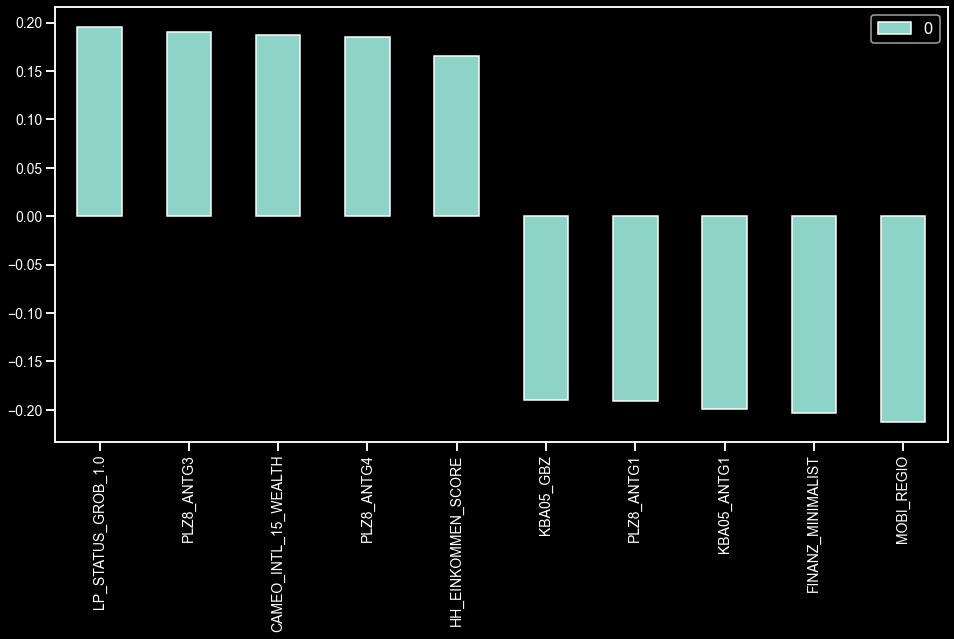

<Figure size 864x576 with 0 Axes>

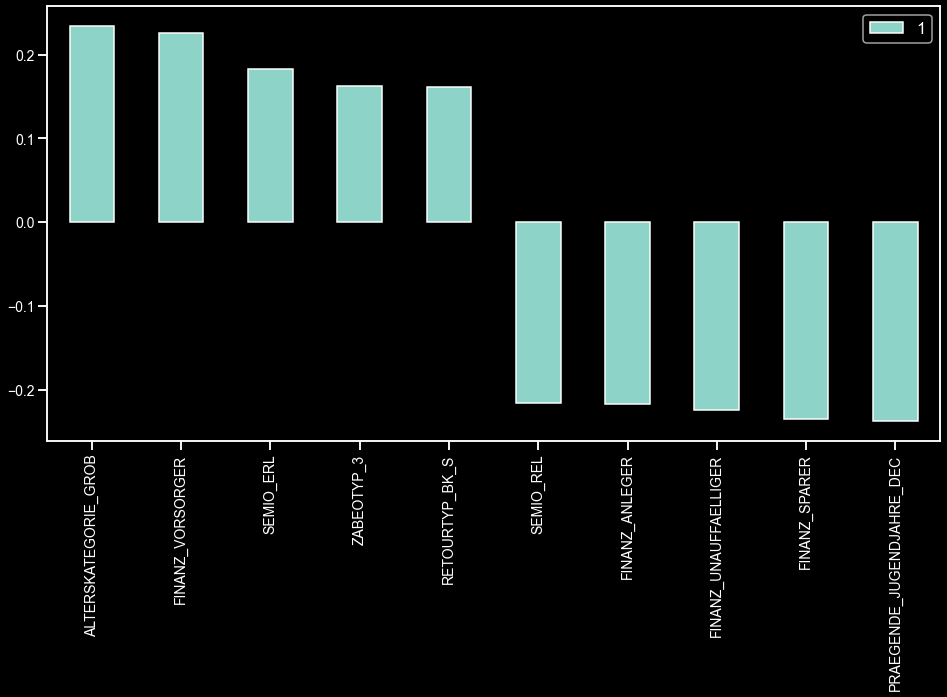

In [58]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
for i in range(3):
    comp_df = pca_results(azdias_clean_copy2, pca_final_gen, i)
    print('Interpret Principal Component {}'.format(i+1))
    print('---------positive & negative variance features---------',comp_df)


In [59]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def definition(f):
    with open('Data_Dictionary.md', 'r') as searchfile:
        before = collections.deque(maxlen=10)
        for line in searchfile:
            if f in line:
                sys.stdout.writelines(before)
                sys.stdout.write(line)
                sys.stdout.writelines(itertools.islice(searchfile, 15))
                break
    return
definition('SOHO_KZ')
        


### 1.22. SOHO_KZ
Small office / home office flag
- -1: unknown
- 0: no small office/home office
- 1: small office/home office

### 1.23. TITEL_KZ
Academic title flag
- -1: unknown
-  0: unknown
-  1: Dr.
-  2: Dr. Dr.
-  3: Prof.
-  4: Prof. Dr.
-  5: other



### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)


| Dimension | Positive variance description |  Negative variance description |     
| :-:|:------------- |:------------- |
| Dimension 1 |  |   |
|1| CAMEO_DEUG_2015 - low-consumption middleclass; upper class, established middleclass, consumption-oriented middleclass|CAMEO_DEUG_2015 - low-consumption middleclass; upper middleclass, active middleclass, low-consumption middleclass|
| 1 | SOHO_KZ - Small office / home office flag; Having small office contributes more to the variance| - | - |
| 1 | ZABEOTYP - Energy consumption typology; smart| ZABEOTYP - Energy consumption typology; green|
| Dimension 2 |  |   |
| 2 | LP_STATUS_GROB - Social status, rough scale low-income earners (maps to 1-2 in fine scale)| LP_STATUS_GROB - Social status, rough scale; houseowners (maps to 8-9 in fine scale)|
| 2 | PLZ8_ANTG3 - Number of 6-10 family houses in the PLZ8 region| MOBI_REGIO - Movement patterns;|
| 2 | German CAMEO: Wealth / Life Stage Typology, mapped to international code - CAMEO_INTL_2015" combines information on two axes: wealth ('tens'-place ) and life stage.| FINANZ_MINIMALIST - Financial typology, for each dimension:|
| Dimension 3 |  |   |
| 3 | ALTERSKATEGORIE_GROB - Estimated age based on given name analysis; | PRAEGENDE_JUGENDJAHRE - DECADE - Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)|
| 3 | FINANZ_VORSORGER - Financial typology, for each dimension| FINANZ_SPARER, FINANZ_UNAUFFAELLIGER, FINANZ_ANLEGER- Financial typology, for each dimension:|
| 3 | SEMIO_ERL - Personality typology, for each dimension|  - |
| 3 | ZABEOTYP - Energy consumption typology; fair supplied|  - |

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [60]:
%%time
# Over a number of different cluster counts...
# Try instantiating a model with 5 centers

kmeans_5 = KMeans(n_clusters=5)

    # run k-means clustering on the data and...
 # Then fit the model to your data using the fit method
model_5 = kmeans_5.fit(X_pca_final_gen)
print(model_5)   
    
    # compute the average within-cluster distances.
score_5 = np.abs(model_5.score(X_pca_final_gen))
print(score_5)

KMeans(n_clusters=5)
52706385.363352746
CPU times: user 50.3 s, sys: 8.94 s, total: 59.3 s
Wall time: 8.75 s


In [61]:
%%time
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score



CPU times: user 9 µs, sys: 20 µs, total: 29 µs
Wall time: 6.91 µs


Score after k value, 3  is: [73098695.99949549, 64105372.27308115, 58917420.18930764]
Score after k value, 7  is: [73098695.99949549, 64105372.27308115, 58917420.18930764, 55515529.74702119, 52706397.437171474, 50501375.00536645, 48894462.39991253]
Score after k value, 11  is: [73098695.99949549, 64105372.27308115, 58917420.18930764, 55515529.74702119, 52706397.437171474, 50501375.00536645, 48894462.39991253, 47421074.30554561, 46614632.903397486, 45195499.6796601, 44185601.23818839]
Score after k value, 15  is: [73098695.99949549, 64105372.27308115, 58917420.18930764, 55515529.74702119, 52706397.437171474, 50501375.00536645, 48894462.39991253, 47421074.30554561, 46614632.903397486, 45195499.6796601, 44185601.23818839, 43538053.12295361, 42833768.02368893, 42181270.5754855, 41439477.212607995]
Score after k value, 19  is: [73098695.99949549, 64105372.27308115, 58917420.18930764, 55515529.74702119, 52706397.437171474, 50501375.00536645, 48894462.39991253, 47421074.30554561, 46614632.903

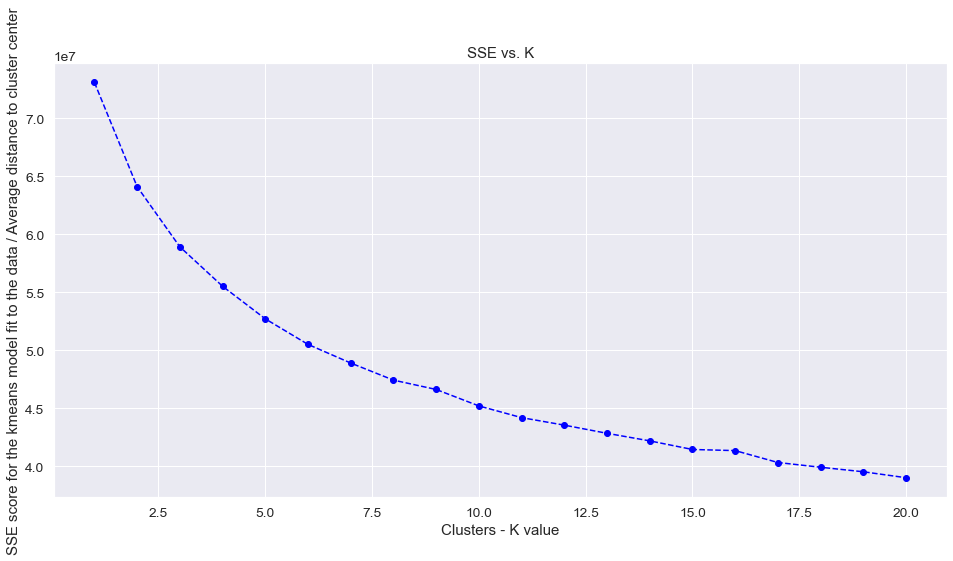

In [62]:
scores = []
centers = list(range(1,21))
count = 1

for center in centers:
    scores.append(get_kmeans_score(X_pca_final_gen, center))
    count+=1
    if count % 4 == 0:
        print('Score after k value, {}  is: {}'.format(center, scores))
        
sns.set(rc={'figure.figsize':(16,8)},font_scale=1.25)
plt.plot(centers, scores, linestyle='--', marker='o', color='blue');
plt.xlabel('Clusters - K value');
plt.ylabel('SSE score for the kmeans model fit to the data / Average distance to cluster center');
plt.title('SSE vs. K');

In [63]:
%%time
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# Over a number of different cluster counts...
kmeans_7 = KMeans(7)
    # run k-means clustering on the data and...
model_7 = kmeans_7.fit(X_pca_final_gen)  
    # compute the average within-cluster distances.
score_7 = np.abs(model_7.score(X_pca_final_gen))
print(score_7)

48894444.061238095
CPU times: user 1min 12s, sys: 10.5 s, total: 1min 22s
Wall time: 12.2 s


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)
    
    --> It is difficult to find a perfect cluster elbow using elbow method
    --> The graph shows that as no. of cluster increases, the average distance form the center decreases
    --> In this case, I can see the graph drop down at hisher rate until 7, so I tried refitting the model with 7 clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [64]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141176.000000,141176.000000,141176.000000
mean,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,...,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.824850,5.119517,2.898510
std,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,...,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.012415,2.159184,1.422683
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,-1.000000,3.000000,1.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,4.000000,2.000000
50%,0.000000,3.000000,1.000000,4.000000,4.000000,1.000000,5.000000,2.000000,2.000000,3.000000,...,3.000000,3.000000,1.000000,0.000000,1.000000,3.000000,4.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,6.000000,5.000000,4.000000,5.000000,5.000000,5.000000,3.000000,...,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000


In [77]:
%%time
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv',sep=';')
# cleaning the data
cust_clean, feat_info_clean = clean_data(customers)
print('\n\n************************************************  Data cleaning complete    ***************************************************')

# Apply feature scaling to the general population demographics data. 
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_fit_trans = imp_mean.fit_transform(cust_clean)
cust_scaling_1 = scaler.fit_transform(imp_fit_trans)
cust_scaling = pd.DataFrame(cust_scaling_1, columns=list(imp_fit_trans))
print('\n\n************************************************  Data scaling complete    ****************************************************')
# Apply PCA to the data.
pca = PCA(n_components=40) #50% of imputed and scaled output
X_pca = pca.fit_transform(cust_scaling) # review comment
#X_pca = pca.transform(cust_scaling)
scree_plot(pca)
print('\n\n************************************************  PCA 1st Phase complete    **********************************************************')
for comp in range(2, cust_scaling.shape[1]):
    pca, X_pca = do_pca(comp, cust_scaling)
    #print("With  {} components, explained variance is {}.".format(comp, pca.explained_variance_ratio_.sum()))
    if(pca.explained_variance_ratio_.sum()>.70):
        pca_final = pca.explained_variance_ratio_.sum()
        final_comp = comp
        break
print('\n\n Variance od {:.4f}% is achieved with {} components, Reapply the PCA'.format((pca.explained_variance_ratio_.sum())*100,final_comp))
print('\n\n************************************************  PCA 3rd phase complete    **********************************************************')
pca_final, X_pca_final = do_pca(final_comp, cust_scaling)
for i in range(3):
    comp_df = pca_results(cust_clean, pca_final, i)
    print('Interpret Principal Component {}'.format(i+1))
    print('---------top 5 positive & negative variance features---------',comp_df)
print('\n\n***************************************** Interpret Principal Component phase complete    **********************************************************')





************************************************  Data cleaning complete    ***************************************************


************************************************  Data scaling complete    ****************************************************


NotFittedError: This PCA instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Score after k value, 3  is: [9291058.438295508, 6988387.287828755, 6095572.574668374]
Score after k value, 7  is: [9291058.438295508, 6988387.287828755, 6095572.574668374, 5477562.449644129, 5086458.994636888, 4765968.186400278, 4403765.635289366]
Score after k value, 11  is: [9291058.438295508, 6988387.287828755, 6095572.574668374, 5477562.449644129, 5086458.994636888, 4765968.186400278, 4403765.635289366, 4113192.6176950266, 3926834.7301786887, 3794381.0221546013, 3624735.5193011537]
Score after k value, 15  is: [9291058.438295508, 6988387.287828755, 6095572.574668374, 5477562.449644129, 5086458.994636888, 4765968.186400278, 4403765.635289366, 4113192.6176950266, 3926834.7301786887, 3794381.0221546013, 3624735.5193011537, 3515542.7048612763, 3393423.006492643, 3263972.347406167, 3179824.6526045785]
Score after k value, 19  is: [9291058.438295508, 6988387.287828755, 6095572.574668374, 5477562.449644129, 5086458.994636888, 4765968.186400278, 4403765.635289366, 4113192.6176950266, 39268

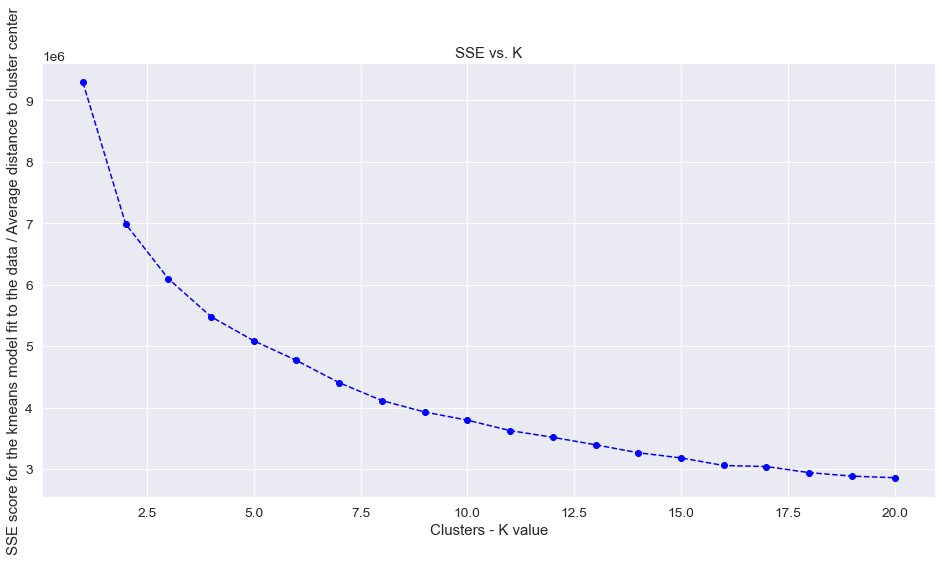

In [66]:
scores = []
centers = list(range(1,21))
count = 1

for center in centers:
    scores.append(get_kmeans_score(X_pca_final, center))
    count+=1
    if count % 4 == 0:
        print('Score after k value, {}  is: {}'.format(center, scores))
        
sns.set(rc={'figure.figsize':(16,8)},font_scale=1.25)
plt.plot(centers, scores, linestyle='--', marker='o', color='blue');
plt.xlabel('Clusters - K value');
plt.ylabel('SSE score for the kmeans model fit to the data / Average distance to cluster center');
plt.title('SSE vs. K');
print('\n\n***************************************************** Final Clustering complete    **********************************************************************')

In [67]:
clusters = input("Enter the number of clusters based on the elbow method \t")
print('Refitting the score with {} clusters'.format(clusters))
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# Over a number of different cluster counts...
kmeans = KMeans(clusters)
    # run k-means clustering on the data and...
model = kmeans_7.fit(X_pca_final)  
    # compute the average within-cluster distances.
score = np.abs(model_7.score(X_pca_final))
print(score_7)
print('Score is {}, after refitting the model with {} clusters'.format(score,clusters))

Enter the number of clusters based on the elbow method 	7
Refitting the score with 7 clusters
48894444.061238095
Score is 4437724.534161766, after refitting the model with 7 clusters


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [69]:
def fit_kmeans(data, centers):
    '''
    INPUT:
        data = the dataset you would like to fit kmeans to (dataframe)
        centers = the number of centroids (int)
    OUTPUT:
        labels - the labels for each datapoint to which group it belongs (nparray)
    
    '''
    kmeans = KMeans(centers)
    labels = kmeans.fit_predict(data)
    #labels = kmeans.predict(data)
    return labels
labels_cust = fit_kmeans(X_pca_final, 8) #fit kmeans to get the labels
print('Customer prediction',labels_cust.shape)
print('Customer data',X_pca_final.shape)
print('Customer data',labels_cust)

labels_gen = fit_kmeans(X_pca_final_gen, 8) #fit kmeans to get the labels
print('General Population prediction',labels_gen.shape)
print('General Population data',X_pca_final_gen.shape)
print('Customer data',pca_final_gen)
    
# Plot the original data with clusters
#plt.scatter(df['height'], df['weight'], c=labels_cust, cmap='Set1');

Customer prediction (191652,)
Customer data (191652, 17)
Customer data [2 7 3 ... 2 6 7]
General Population prediction (891221,)
General Population data (891221, 31)
Customer data PCA(n_components=31)


/Users/pp/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/pp/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:title={'center':'General population prediction'}, ylabel='count'>

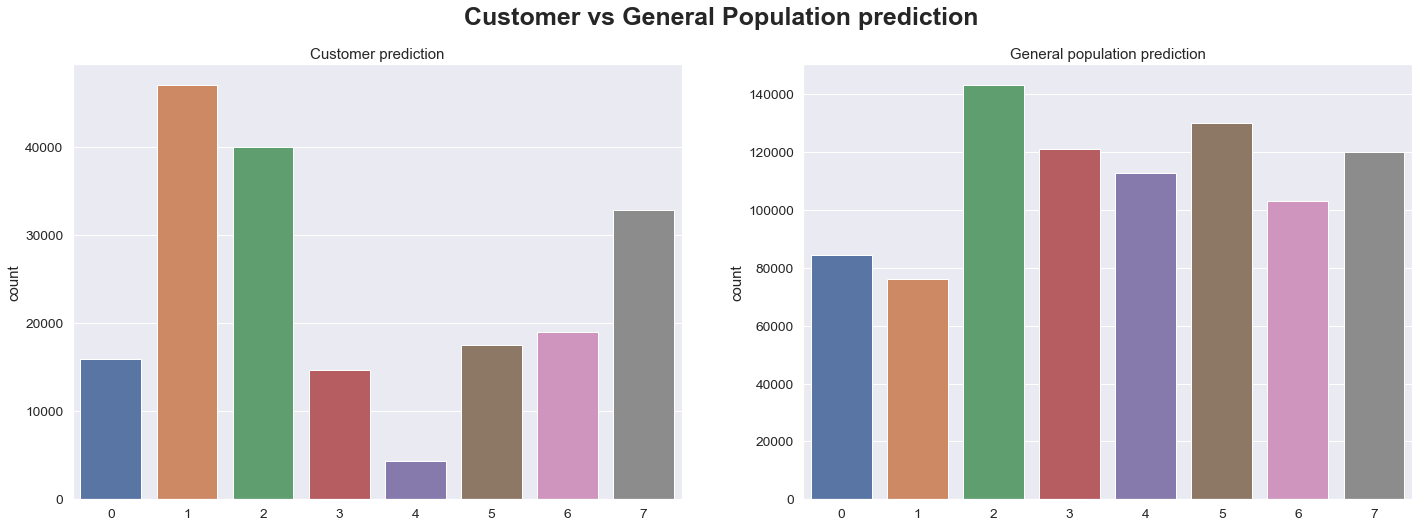

In [70]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
sns.set(rc={'figure.figsize':(24,8)},font_scale=1.25)
fig, axes = plt.subplots(1,2)
fig.suptitle('Customer vs General Population prediction',fontweight="bold", fontsize=25)
axes[0].title.set_text('Customer prediction')
sns.countplot(labels_cust, ax=axes[0])
axes[1].title.set_text('General population prediction')
sns.countplot(labels_gen, ax=axes[1])

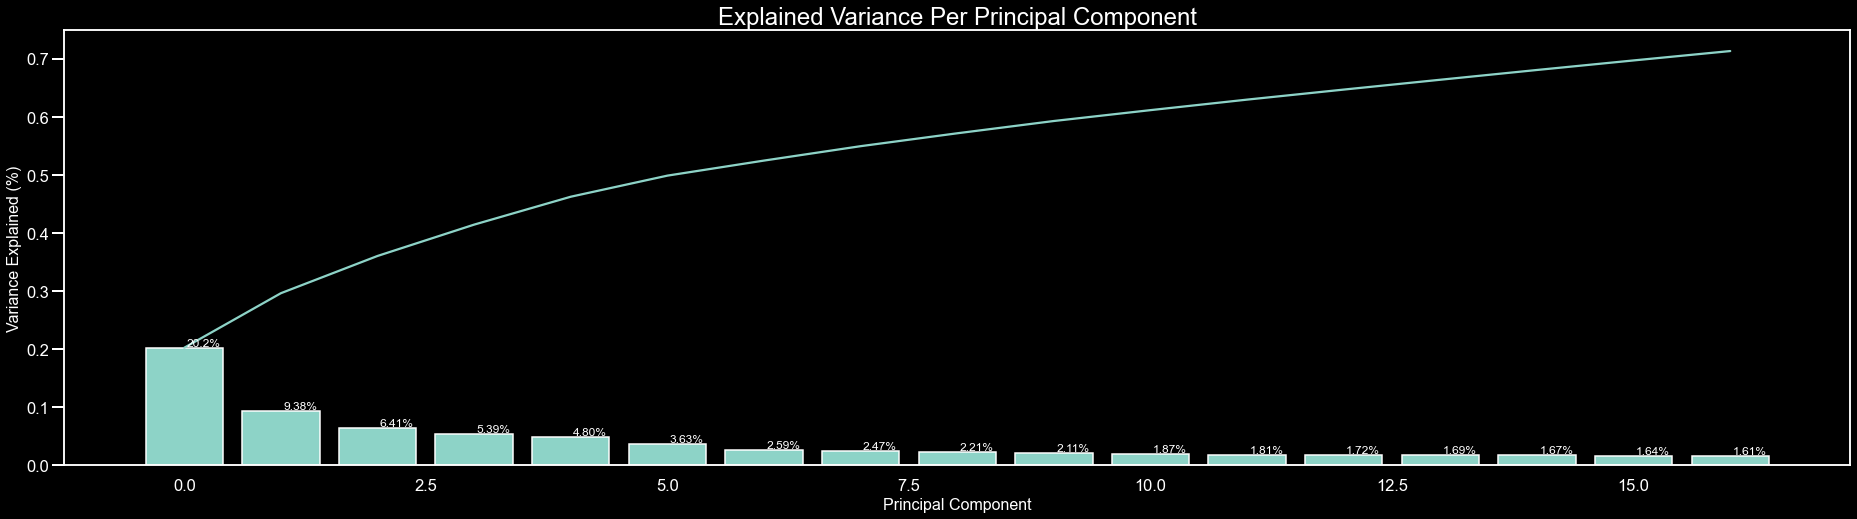

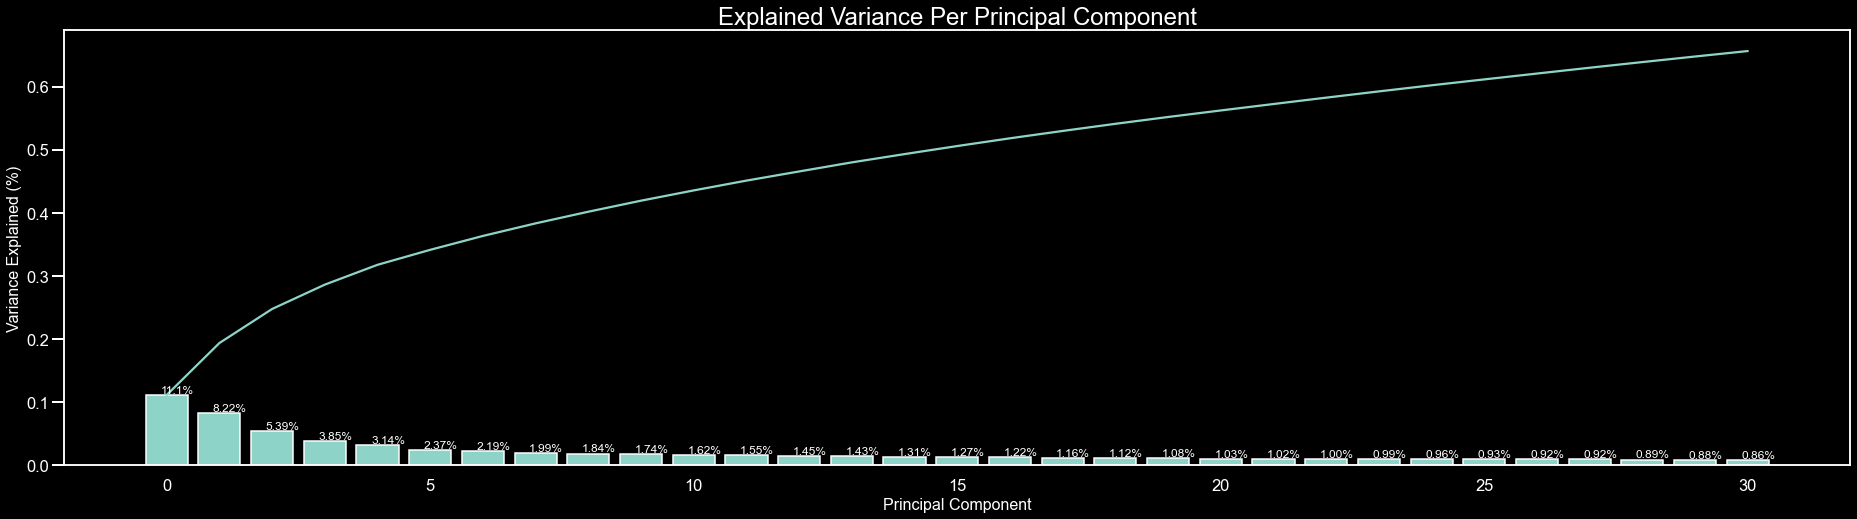

In [71]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
cust = scree_plot(pca_final)
general = scree_plot(pca_final_gen)


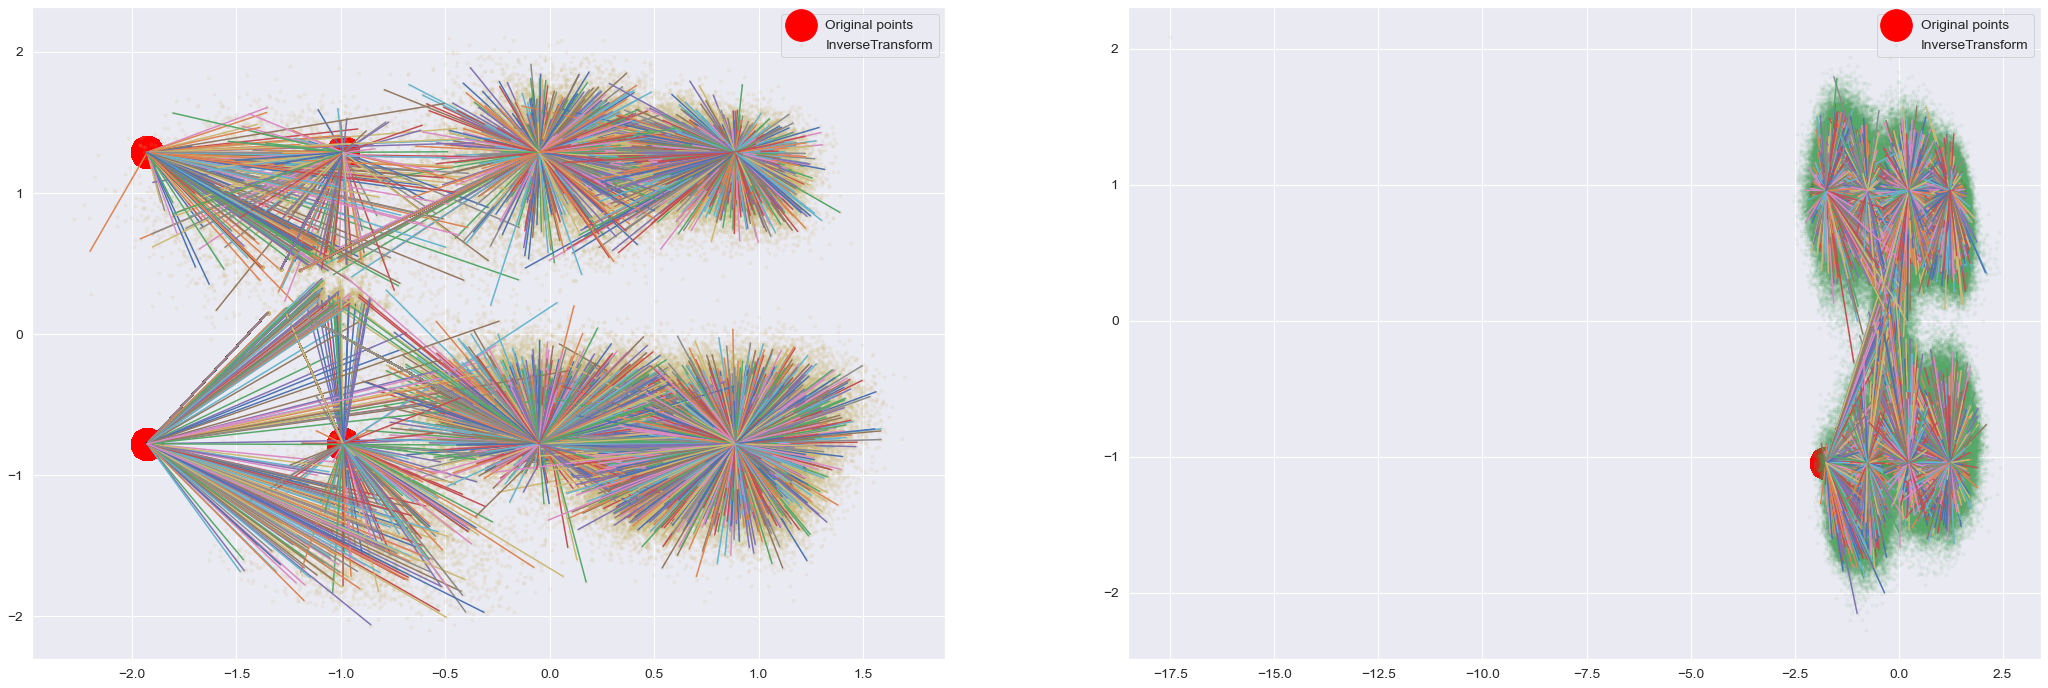

In [72]:
fig.suptitle('Compare Customer Data to Demographics Data',fontweight="bold", fontsize=25)

#X_re_orig = pca_final.inverse_transform(pca_final.fit_transform(cust_scaling))
#X_re_orig_gen = pca_final_gen.inverse_transform(pca_final_gen.fit_transform(azdias_scaling))

X_re_orig = pca_final.inverse_transform(pca_final.transform(cust_scaling))
X_re_orig_gen = pca_final_gen.inverse_transform(pca_final_gen.transform(azdias_scaling))


sns.set(rc={'figure.figsize':(36,12)},font_scale=1.25)
plt.subplot(1, 2, 1)
plt.scatter(cust_scaling[:, 0], cust_scaling[:, 1], label='Original points', color = 'Red', s=1000)
plt.scatter(X_re_orig[:, 0], X_re_orig[:, 1], label='InverseTransform', color = 'y', marker='.',  alpha = 1/10)
[plt.plot([cust_scaling[i, 0], X_re_orig[i, 0]], [cust_scaling[i, 1], X_re_orig[i, 1]]) for i in range(10000)]
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(azdias_scaling[:, 0], azdias_scaling[:, 1], label='Original points', color = 'Red', s=1000)
plt.scatter(X_re_orig_gen[:, 0], X_re_orig_gen[:, 1], label='InverseTransform', color = 'g', marker='.',  alpha = 1/20)
[plt.plot([azdias_scaling[i, 0], X_re_orig_gen[i, 0]], [azdias_scaling[i, 1], X_re_orig_gen[i, 1]]) for i in range(10000)]
plt.legend()
plt.show()
#Ref: https://stackoverflow.com/questions/55533116/pca-inverse-transform-in-sklearn
#Ref: https://julienbeaulieu.gitbook.io/wiki/sciences/programming/data-analysis/data-visualization/bivariate-exploration-of-data/overplotting-transparency-and-jitter

Interpret Principal Component 1 for Customer data
---------positive & negative variance features---------                         16
SOHO_KZ             0.4238
CJT_GESAMTTYP_5.0   0.3848
ZABEOTYP_2          0.2480
FINANZTYP_6         0.2354
LP_STATUS_FEIN_6.0  0.2147
LP_STATUS_FEIN_7.0 -0.1456
LP_STATUS_FEIN_4.0 -0.1907
CJT_GESAMTTYP_4.0  -0.2313
FINANZTYP_2        -0.2492
CJT_GESAMTTYP_3.0  -0.2748
Interpret Principal Component 2 for Customer data
---------positive & negative variance features---------                             0
FINANZ_ANLEGER         0.2442
FINANZTYP_4            0.2437
FINANZ_SPARER          0.2419
LP_STATUS_FEIN_5.0     0.2336
FINANZ_UNAUFFAELLIGER  0.2297
SEMIO_SOZ             -0.1694
FINANZ_MINIMALIST     -0.1951
FINANZ_VORSORGER      -0.2123
ALTERSKATEGORIE_GROB  -0.2124
SEMIO_VERT            -0.2289
Interpret Principal Component 3 for Customer data
---------positive & negative variance features---------                                 1
FINANZ_HAUSBAUER     

<Figure size 864x576 with 0 Axes>

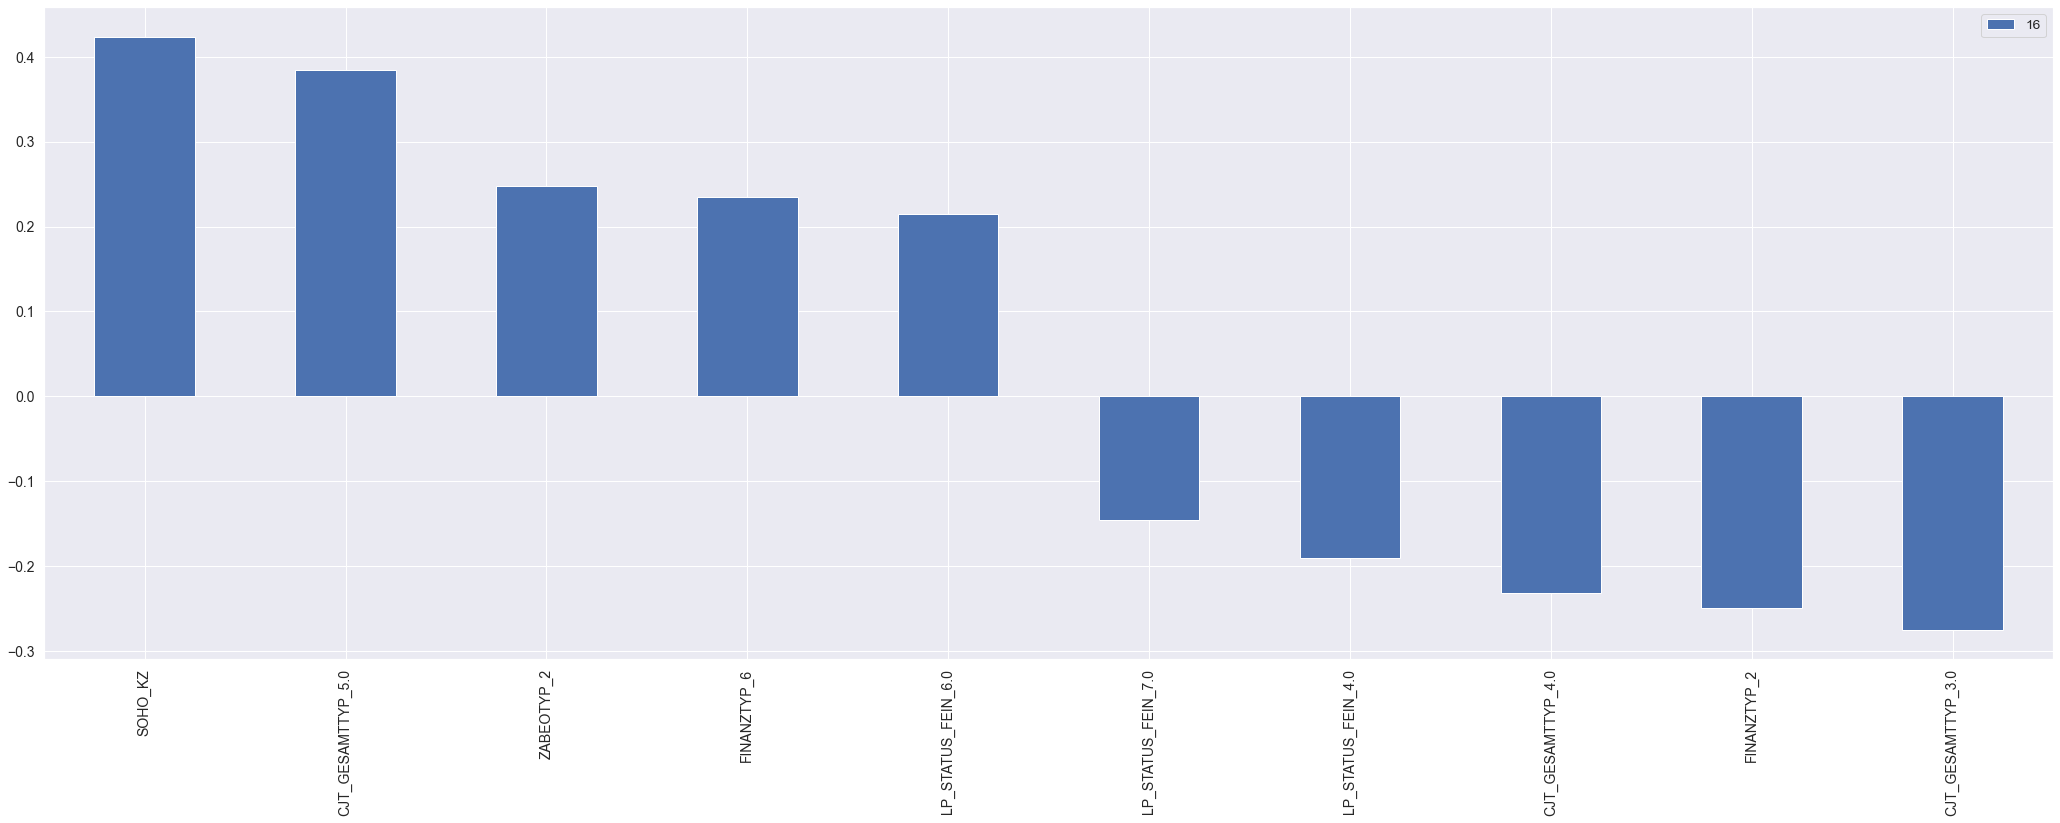

<Figure size 864x576 with 0 Axes>

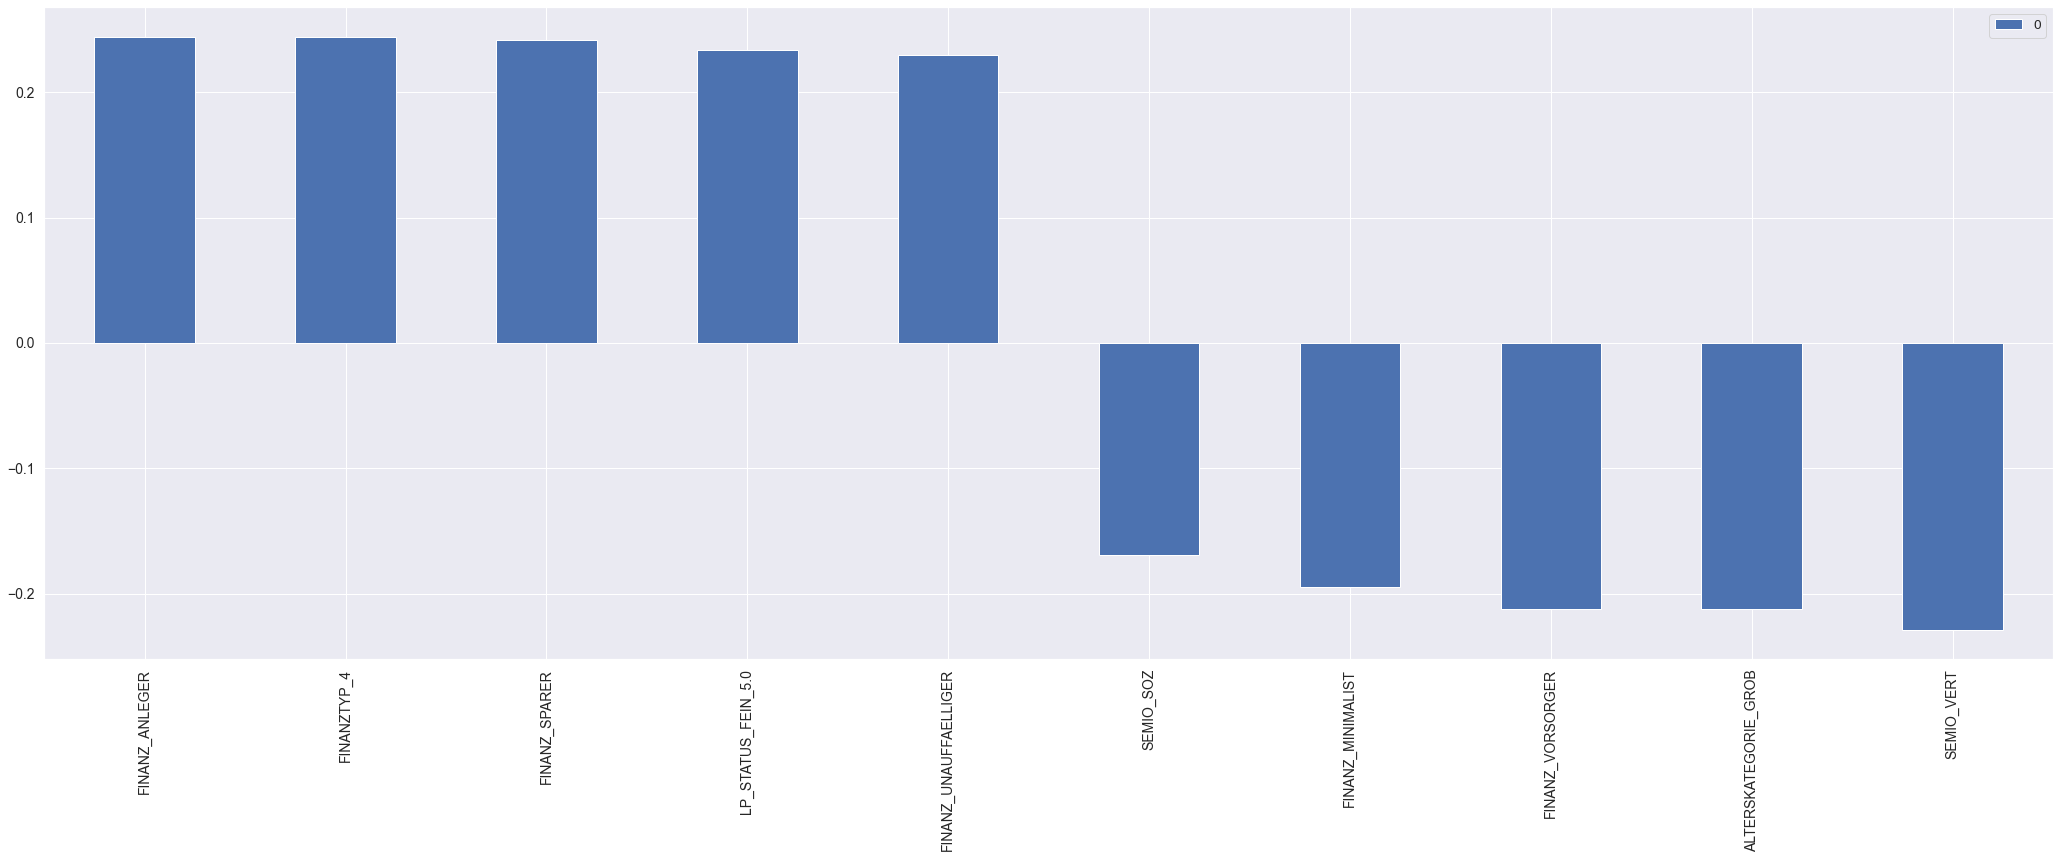

<Figure size 864x576 with 0 Axes>

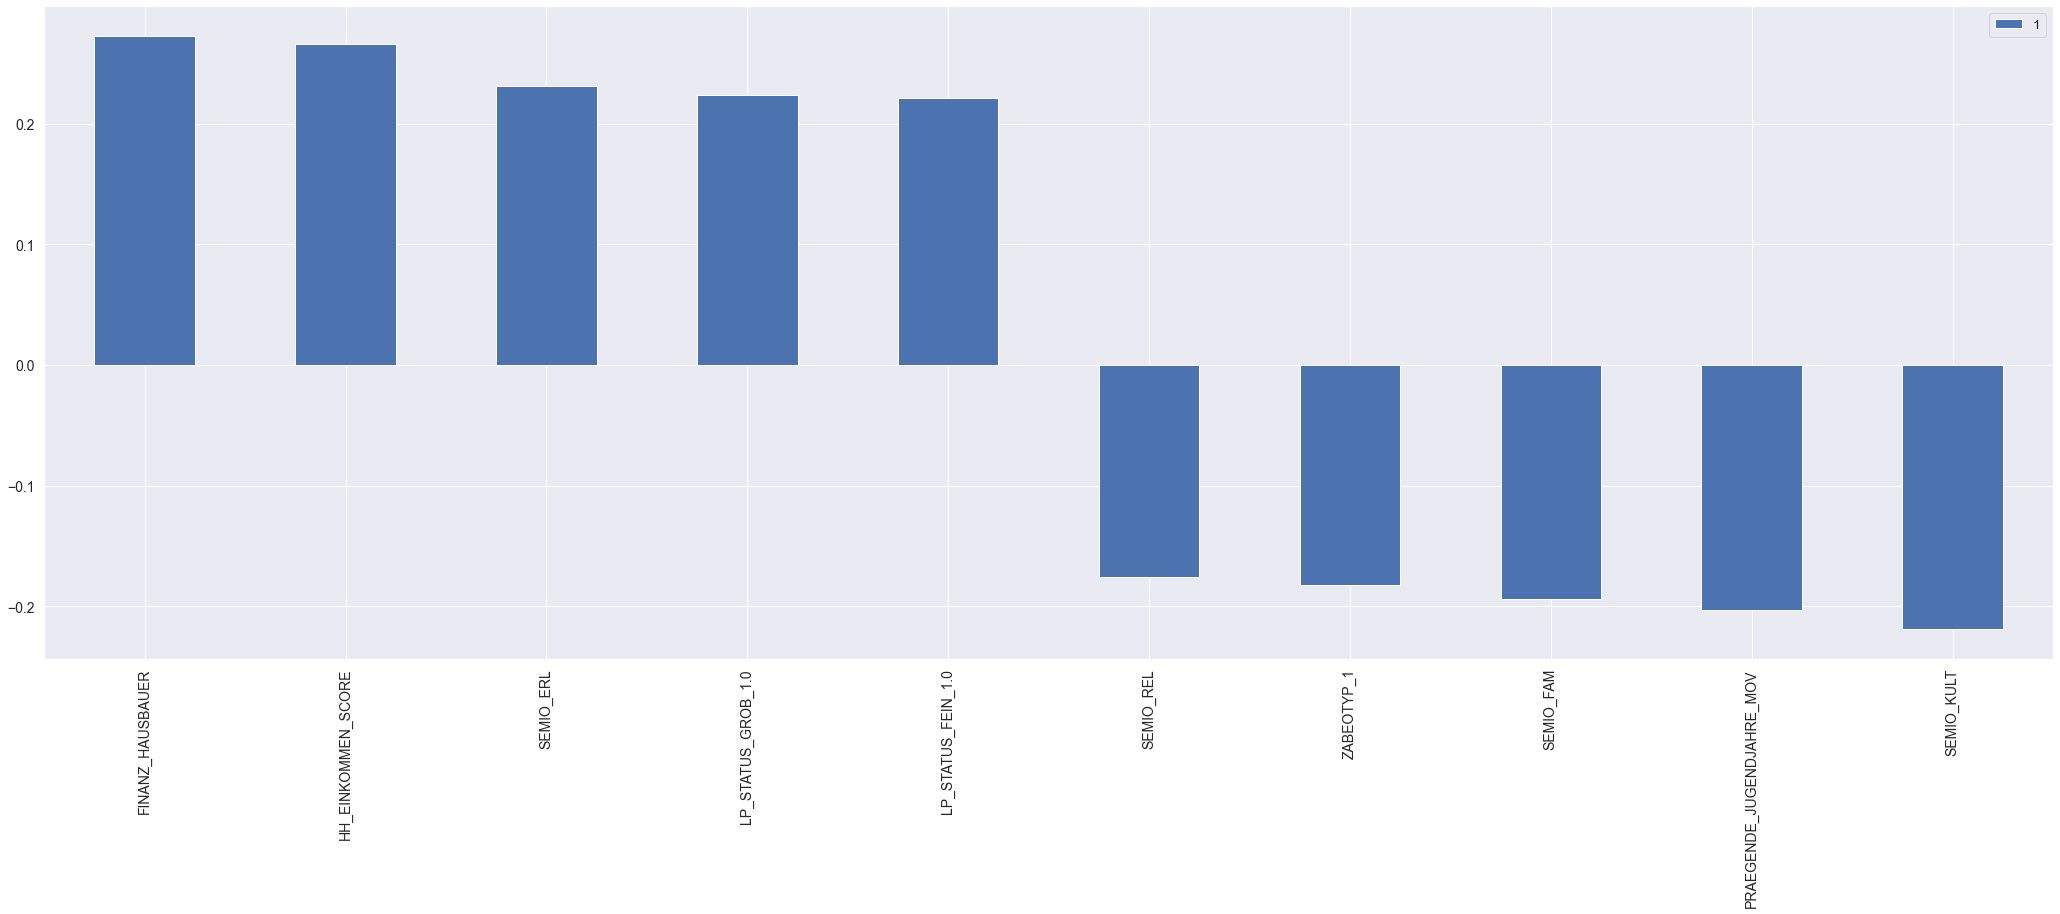

In [73]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

for i in range(3):
    comp_df = pca_results(cust_clean, pca_final, i)
    print('Interpret Principal Component {} for Customer data'.format(i+1))
    print('---------positive & negative variance features---------',comp_df)
    

Interpret Principal Component 1 for Demographic data
---------positive & negative variance features---------                        30
CAMEO_DEUG_2015_7  0.3720
CAMEO_DEUG_2015_6  0.2608
GEBAEUDETYP_6.0    0.2190
GEBAEUDETYP_4.0    0.2051
CAMEO_DEUG_2015_3  0.1884
CAMEO_DEUG_2015_1 -0.1518
GEBAEUDETYP_2.0   -0.1984
CAMEO_DEUG_2015_8 -0.2575
CAMEO_DEUG_2015_5 -0.2774
CAMEO_DEUG_2015_4 -0.3610
Interpret Principal Component 2 for Demographic data
---------positive & negative variance features---------                            0
LP_STATUS_GROB_1.0    0.1959
PLZ8_ANTG3            0.1906
CAMEO_INTL_15_WEALTH  0.1873
PLZ8_ANTG4            0.1848
HH_EINKOMMEN_SCORE    0.1659
KBA05_GBZ            -0.1897
PLZ8_ANTG1           -0.1906
KBA05_ANTG1          -0.1991
FINANZ_MINIMALIST    -0.2033
MOBI_REGIO           -0.2126
Interpret Principal Component 3 for Demographic data
---------positive & negative variance features---------                                 1
ALTERSKATEGORIE_GROB       0.2341


<Figure size 864x576 with 0 Axes>

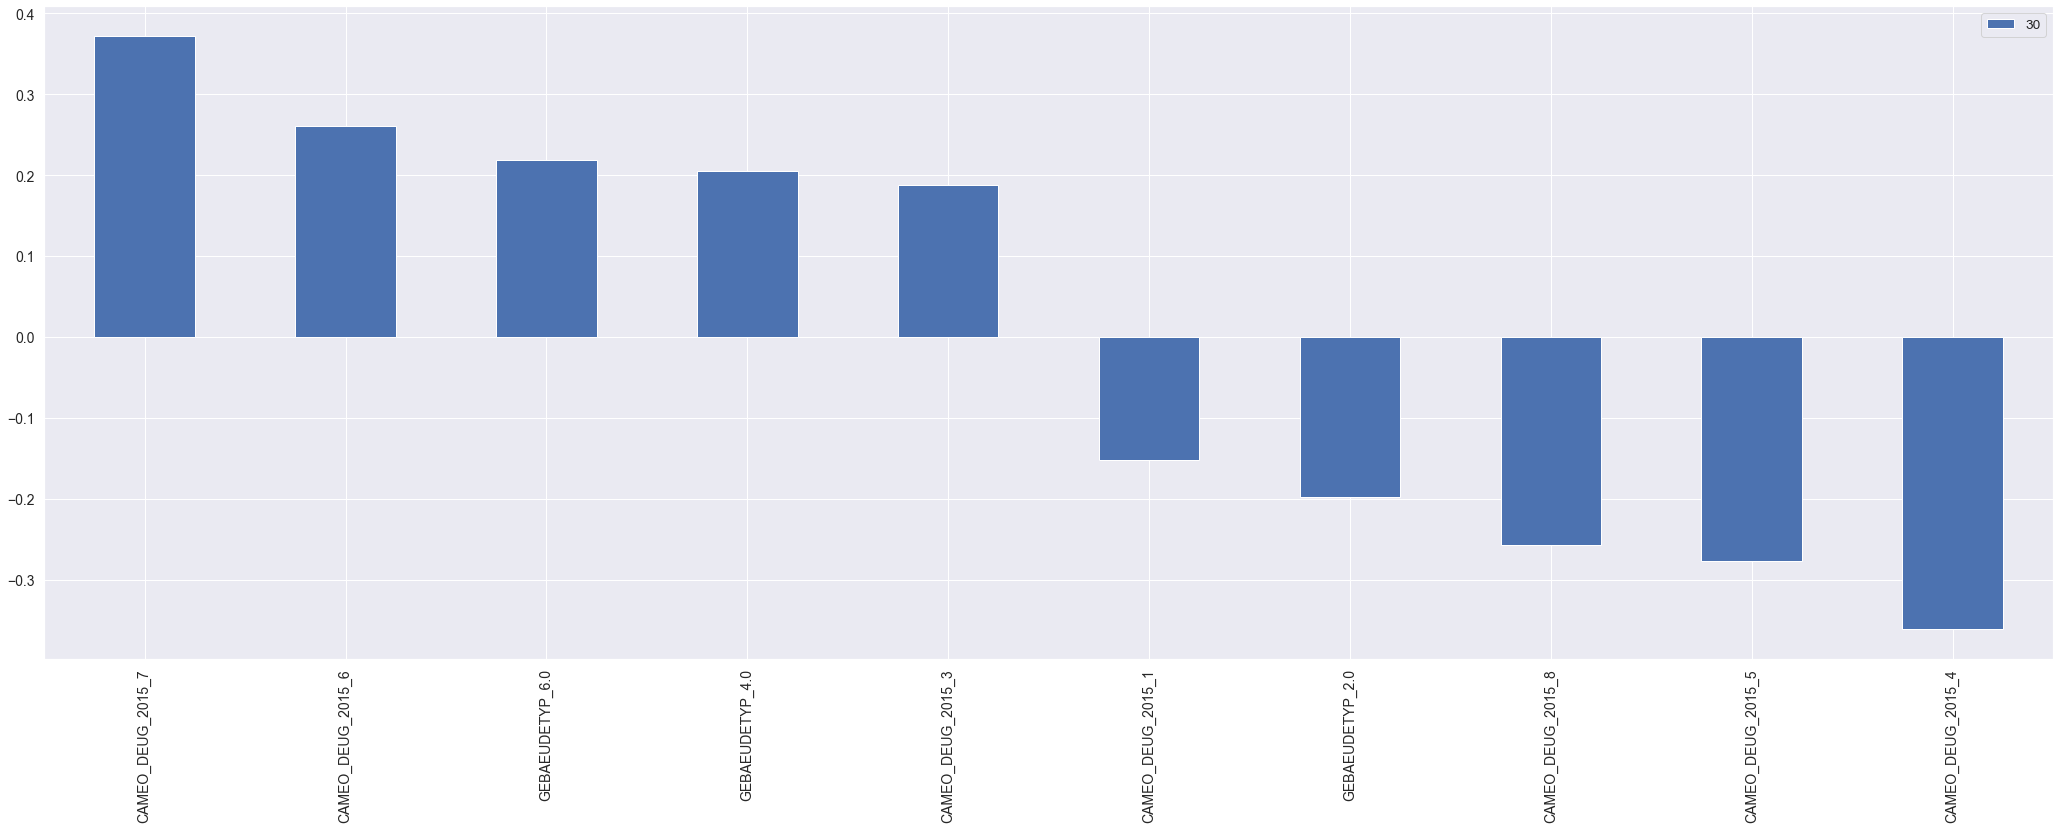

<Figure size 864x576 with 0 Axes>

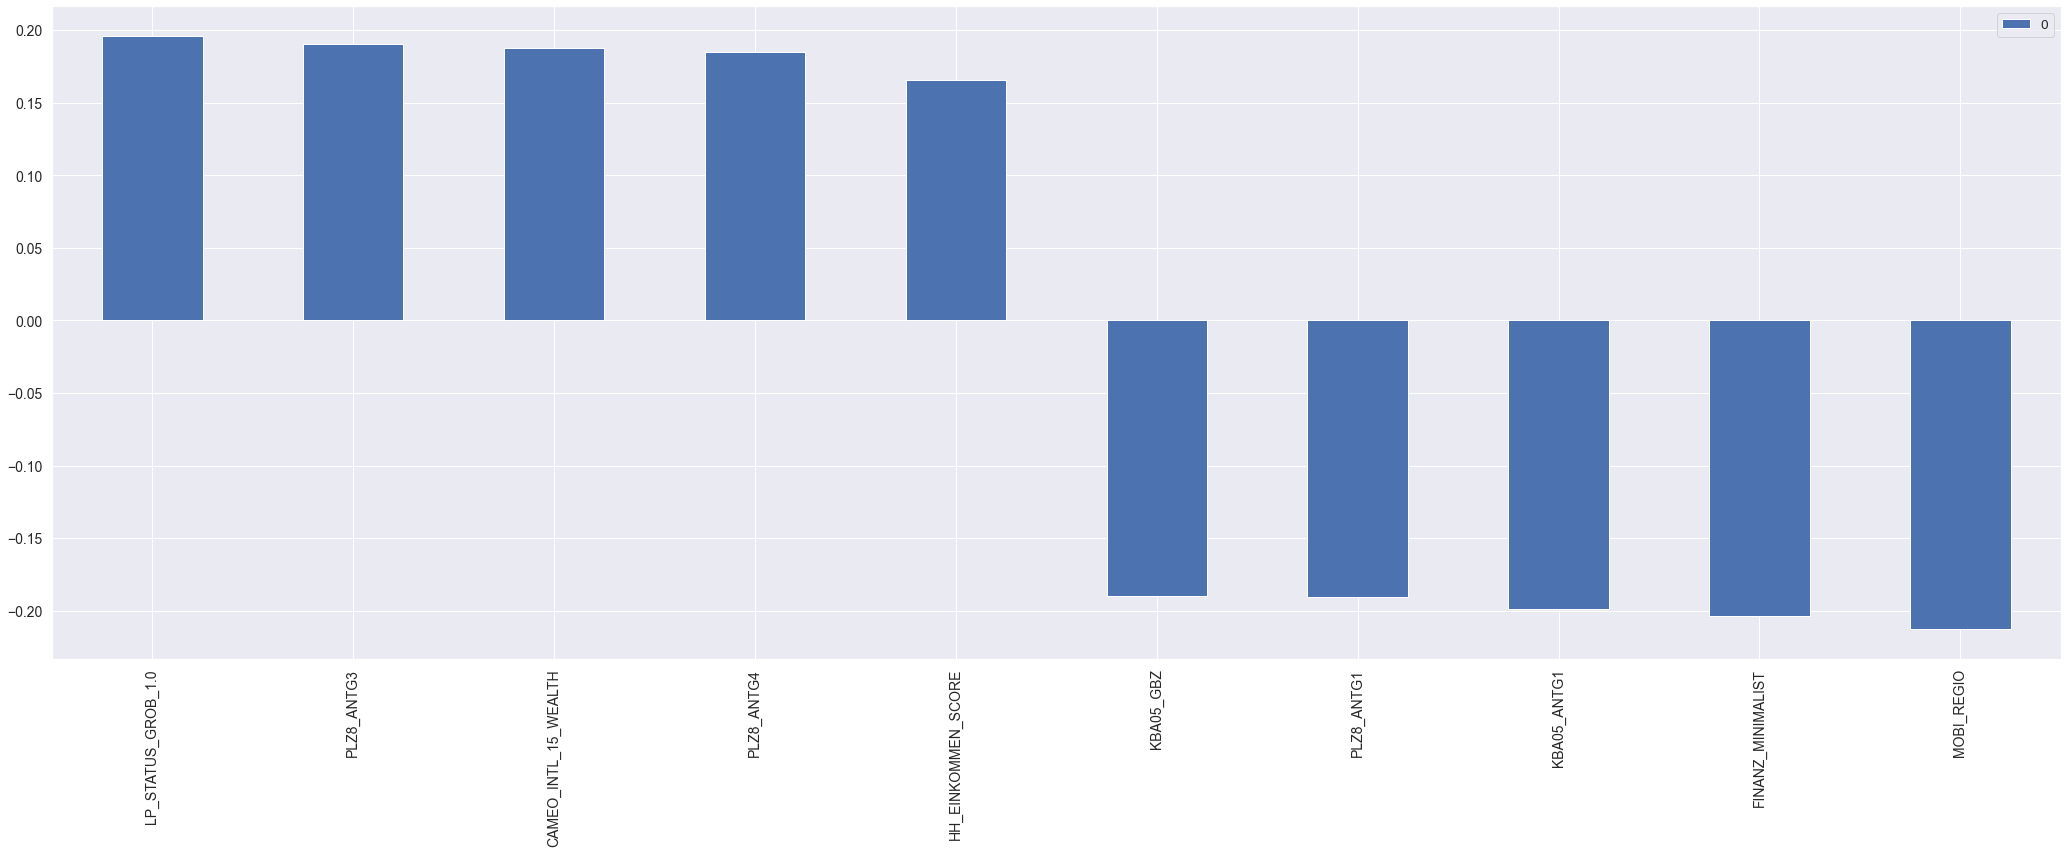

<Figure size 864x576 with 0 Axes>

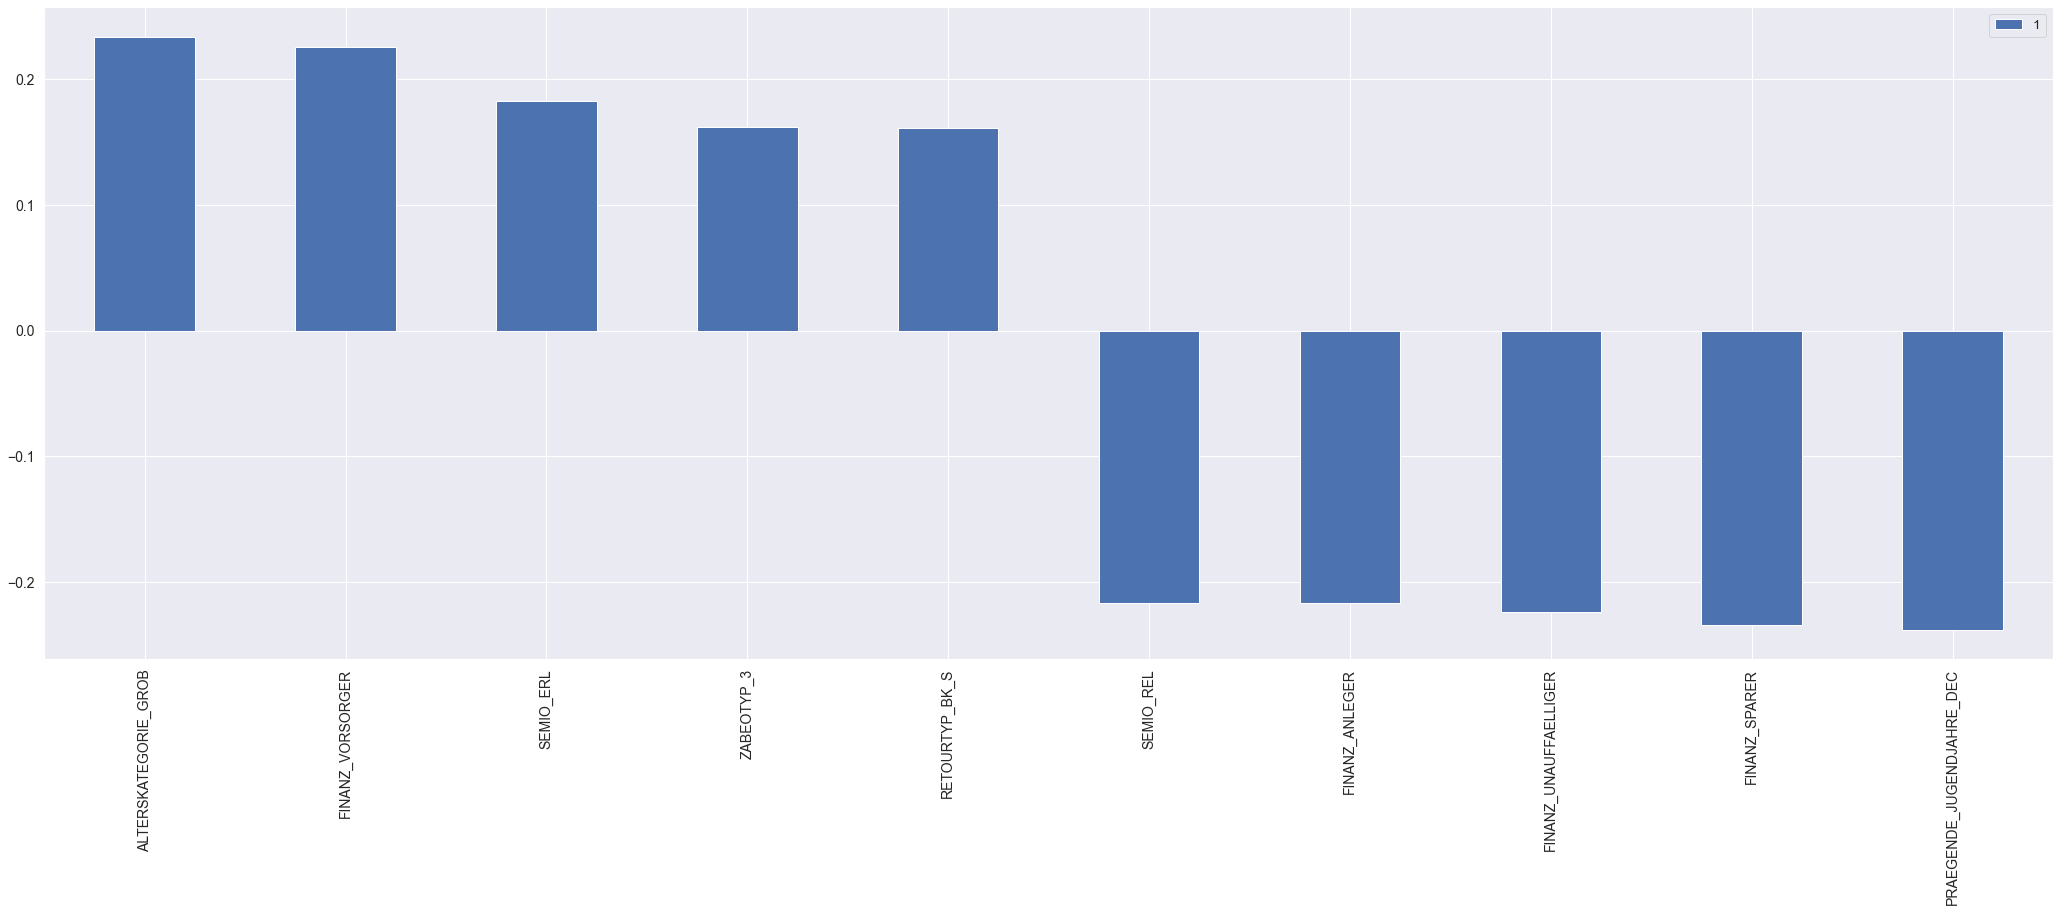

In [74]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

for i in range(3):
    comp_df = pca_results(azdias_clean_copy2, pca_final_gen, i)
    print('Interpret Principal Component {} for Demographic data'.format(i+1))
    print('---------positive & negative variance features---------',comp_df)

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)


|Positive variance Demographic |  Positive variance Customer | Negative variance Demographic |  Negative variance Customer | 
|:------------- |:------------- |:------------- |:------------- |
| Positive segment comparison || Negative features comparison||
| Shopper typology - Shopper typology| Small office / home office flag |low-consumption middleclass; urban working class & onsumption-oriented middleclass| Customer-Journey-Typology: preferred information and buying channels for consumer;advertisinginterested Online-shopper |
| low-consumption middleclass - working class & upper middleclass| Customer-Journey-Typology: preferred information and consumer |Movement patterns| Most descriptive financial type for individual; money-saver|
| Customer-Journey-Typology: preferred information and buying channels for consumer - Advertising- and Cross-Channel-Enthusiast| Energy consumption typology |Financial typology| Social status, fine scale; villagers|
| Small office / home office flag | Financial typology, for each dimension |Dominating movement of person's youth - Decade|, Dominating movement of person's youth - Movement |
| Energy consumption typology - smart | Most descriptive financial type for individual; be prepared |Number of 1-2 family houses in the microcell; lower share of 1-2 family homes| Personality typology, for each dimension |
| Social status, rough scale - low-income earners | Financial typology |Number of 1-2 family houses in the PLZ8 region; lower share of 1-2 family homes| Estimated age based on given name analysis |
| Estimated age based on given name analysis | Estimated household net income | Customer-Journey-Typology: preferred information and buying channels for consumer; Advertising- and Consumptiontraditionalist| Personality typology, for each dimension|

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [75]:
print('notebook executed successfully !!!')

notebook executed successfully !!!
